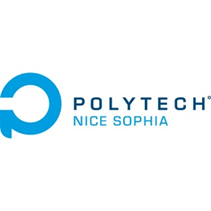


# Kite electricity energy production project (KEEP Project)   

### Lheureux Dylan
### Mari Mathieu
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## **Summary**

## I- [Introduction](#ID1)  
1) [Introduction to GitLab](#ID2)  
2) [Introduction to Julia](#ID3)  
3) [Introduction of the subject](#ID4)  

## II-[Display of the limit cycle and power](#ID5)  
1) [Code conversion : from Python to Julia](#ID6)  
2) [Calculation and display and of the kite sail trajectory](#ID7)  
3) [Calculation of the power produced by the system](#ID8)  

## III) [Optimization](#ID9)  
1) [Influence of Cmax on the power](#ID10)  
2) [Influence of alpha_p_max on the power](#ID11)  
3) [Influence of r on the power](#ID12)  

## IV - [CONCLUSION](#ID13)  
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<a id='ID1'>

## **I- Introduction**

<a id='ID2'>

### 1) Introduction to GitLab

As part of our project, we discovered GitLab, which made it easier and more efficient to manage the files containing the code or documents made available. Here is an example of the structure of our project and how it was managed :

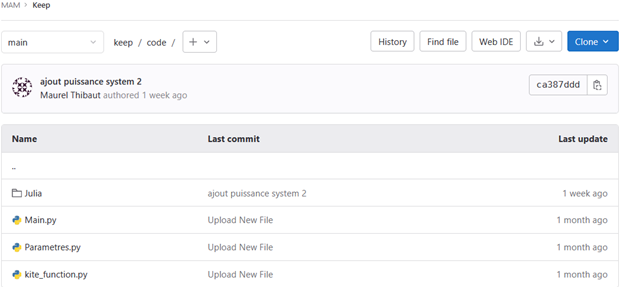

For most of us, we only knew GitLab by name and it took a little bit of time to get hold of it because we had to link our GitLab account with Jupyter. However, this allowed us to make our task easier because, when someone was working on the project he could then directly add his contribution to the repository. This also allowed to have a trace of the codes that we had already done because everything is versioned. Indeed, several times we realized an error in the codes, and so we had to look at what we had written to arrive to this error.

<a id='ID3'>

### 2) Introduction to Julia

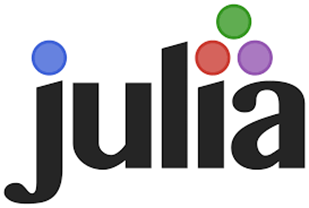

Julia is a high-level programming language, very useful especially for scientific calculations. Created in 2009 and licensed by MIT, it has grown in popularity over the years. This language has the advantage of having the simplicity of use of Python and the performance of C/C++ languages. One of the main difference between Julia and Python is the fact that the index in Julia begin at 1, also their are differences in syntax, for example in python the keyword "def" is used to define a function while in Julia the keyword is "function" or the power is noted "**" in Python and "^" in Julia. The use of Julia was very useful for us to solve the ODE. Moreover, in our project, Julia allowed us to plot some graphs, and also use the feature of broadcast for a function which consist to have a single function to make operations element by element for both a scalar and a vector.

<a id='ID4'>

### 3) Introduction of the subject

This project deal with the production of electricity using a kite sail. Indeed, the force of the wind, driving a movement of the kite sail, will start a generator that will produce electricity. Thus, at first, the objective of this project, is to model the movement of the kite according to different parameters, using a system of differential equations. Then, the goal is to optimize these parameters in order to maximize the production of electricity thanks to the kite sail.

We know that there is a limit cycle in the form of a "eight" if we project the movement into the plane.It means that, after a certain time, the kite movement will converge towards this eight-shaped movement.
To help us in this project, a Python code from students of the engineering school ENSTA Bretagne was provided.
Therefore, we tried to model this limit cycle and to plot the position of the kite as a function of time.

We want to produce energy by rotating the lever arm. The lever is connected to a generator via a multiplier.
To do so, we have the formula that determines the dynamics of our system :   $I_e $ $ \ddot α$ $ = C_r + F_t⋅l⋅𝑠𝑖𝑛(𝜃_2)⋅𝑠𝑖𝑛(𝜙_2)$. Where Cr is the torque of the generator, given by a linear law in function of 𝛼 and kg where kg is the coefficient of the linear law (Torque, speed of rotation) of the generator in N.m.s. The I_eq inertia is the equivalent inertia of the generator and lever.This is the equation we will compute and study in the following parts.

<a id='ID5'>

## **II - Display of the limit cycle and power**

<a id='ID6'>

### 1) Code conversion : from Python to Julia

The entire code that was given to us in this project was coded in Python, so the first thing we had to do was to convert that code into Julia. First of all, the syntaxes are absolutely not the same in Python and in Julia. This is why we had to review most functions written in Python in order to find alternatives better suited to Julia. One of the main problems encountered was to solve the type problem between these two programming languages since Python is rather designed to work with lists but it was more convenient to work with vectors in Julia. 

In addition, we switched to explicit (Ordinary Differential Equations ODE rather than Differential Algebraic Equations DAE ) by factoring the matrix into the second order dynamics : *$ M(z(t),\dot z(t))⋅\ddot z(t)=g(z(t),\dot z(t),p) $* because it was cheaper in calculation than what was done in Python. So, instead of 
```
x=sm/M 
Minv=inv(M)
d2tau,d2R,d2phi_2,d2theta_2,d2alpha = Minv
``` 
we now have :
```
Msoluce = transpose(M\transpose(sm))
d2tau,d2R,d2phi_2,d2theta_2,d2alpha = Msoluce
```

After converting the code into Julia we lost a lot of time to solve errors connecting the two languages. Indeed, we were able to compare the second member obtained in Python with the one obtained in Julia until we obtain the same thing for given initial conditions.After long hours spent trying to find errors not very visible, for instance the constant declared ```I```  in Python which actually corresponds to the identity function in Julia and returns True, thus returning no errors.

However, we were not able to solve all the mistakes. Indeed, despite an identical second member for initial conditions, the ODE solution after integration for a time "t" differs for some dimensions.
Nevertheless, we observed that this problem was less affecting the result for short periods of time, which is why we limited the rest of the study to short periods. 

<a id='ID7'>

### 2) Calculation and display of the sail trajectory  
To calculate the sail trajectory, we had to solve an ODE problem in 11 dimensions.

In [1]:
function systeme2!(dy,y,p,t)
    l, r, theta_0, delta_theta, phi_0, delta_phi, v_ref, Ig, m, alpha_p_max, Cmax,  AoA = p
   
    # We change the name of variables
    
    tau = y[1]
    dtau = y[2]
    alpha = y[3]
    dalpha = y[4]
    theta_2 = y[5]
    dtheta_2 = y[6]
    phi_2 = y[7]
    dphi_2 = y[8]
    R = y[9]
    dR = y[10]
    #Calculation of the angles phi theta and their derivatives
    theta = theta_0+delta_theta*sin(2*tau)
    phi = phi_0+delta_phi*sin(tau)
    dtheta = 2*dtau*delta_theta*cos(2*tau)
    dphi =  dtau*delta_phi*cos(tau)

    Cg =-loi_de_commande(alpha_p_low, alpha_p_max, Cmax, dalpha)

    #Calculation of the real wind and the kite's position.
    V = v_ref*(r*cos(theta_2)/h_ref)^nvent 

    # Calculation of forces
    Fgrav1,Fgrav2,Fgrav3 = forces_grav(theta_2, r, m)
    Faero_l1,Faero_l2,Faero_l3 = forces_aero_l(V, l, r, alpha, theta_2, dalpha,  dtheta_2, phi_2, dphi_2)
    Faero_kite1,Faero_kite2,Faero_kite3 = forces_aerok(V, l, r, alpha, theta_2,phi_2, dalpha,  dtheta_2,  dphi_2, AoA)
    
    #Solving the matrix system
    M = [0 0 m*r*sin(theta_2)*((-sin(phi_2)*cos(alpha)-cos(phi_2)*sin(alpha))*(-delta_phi*cos(tau)*sin(phi)*sin(theta)+2*delta_theta*
cos(2*tau)*cos(phi)*cos(theta))+(-sin(phi_2)*sin(alpha)+cos(phi_2)*cos(alpha))*(delta_phi*cos(tau)*cos(phi)*sin(theta)+2*
delta_theta*cos(2*tau)*sin(phi)*cos(theta))) m*r*((cos(theta_2)*cos(phi_2)*cos(alpha)-cos(theta_2)*sin(phi_2)*sin(alpha))*
(-delta_phi*cos(tau)*sin(phi)*sin(theta)+2*delta_theta*cos(2*tau)*cos(phi)*cos(theta))+(cos(theta_2)*cos(phi_2)*sin(alpha)+cos(theta_2)*
sin(phi_2)*cos(alpha))*(delta_phi*cos(tau)*cos(phi)*sin(theta)+2*delta_theta*cos(2*tau)*sin(phi)*cos(theta))+2*sin(theta_2)*delta_theta*
cos(2*tau)*sin(theta)) (m*l*sin(theta_2)*sin(phi_2)+Ig/l/sin(theta_2)/sin(phi_2))*((sin(theta_2)*cos(phi_2)*cos(alpha)-sin(theta_2)*
sin(phi_2)*sin(alpha))*(-delta_phi*cos(tau)*sin(phi)*sin(theta)+2*delta_theta*cos(2*tau)*cos(phi)*cos(theta))+(sin(theta_2)*cos(phi_2)*
sin(alpha)+sin(theta_2)*sin(phi_2)*cos(alpha))*(delta_phi*cos(tau)*cos(phi)*sin(theta)+2*delta_theta*cos(2*tau)*sin(phi)*cos(theta))-2*
cos(theta_2)*delta_theta*cos(2*tau)*sin(theta))+m*l*cos(theta_2)*sin(phi_2)*((cos(theta_2)*cos(phi_2)*cos(alpha)-cos(theta_2)*sin(phi_2)*
sin(alpha))*(-delta_phi*cos(tau)*sin(phi)*sin(theta)+2*delta_theta*cos(2*tau)*cos(phi)*cos(theta))+(cos(theta_2)*cos(phi_2)*sin(alpha)+
cos(theta_2)*sin(phi_2)*cos(alpha))*(delta_phi*cos(tau)*cos(phi)*sin(theta)+2*delta_theta*cos(2*tau)*sin(phi)*cos(theta))+2*sin(theta_2)*
delta_theta*cos(2*tau)*sin(theta))+m*(r*sin(theta_2)+l*cos(phi_2))*((-sin(phi_2)*cos(alpha)-cos(phi_2)*sin(alpha))*(-delta_phi*cos(tau)*
sin(phi)*sin(theta)+2*delta_theta*cos(2*tau)*cos(phi)*cos(theta))+(-sin(phi_2)*sin(alpha)+cos(phi_2)*cos(alpha))*(delta_phi*cos(tau)*
cos(phi)*sin(theta)+2*delta_theta*cos(2*tau)*sin(phi)*cos(theta)));0 0 m*r*sin(theta_2)*((-sin(phi_2)*cos(alpha)-cos(phi_2)*sin(alpha))*
cos(phi)*sin(theta)+(-sin(phi_2)*sin(alpha)+cos(phi_2)*cos(alpha))*sin(phi)*sin(theta)) m*r*((cos(theta_2)*cos(phi_2)*cos(alpha)-
cos(theta_2)*sin(phi_2)*sin(alpha))*cos(phi)*sin(theta)+(cos(theta_2)*cos(phi_2)*sin(alpha)+cos(theta_2)*sin(phi_2)*cos(alpha))*
sin(phi)*sin(theta)-sin(theta_2)*cos(theta)) (m*l*sin(theta_2)*sin(phi_2)+Ig/l/sin(theta_2)/sin(phi_2))*((sin(theta_2)*cos(phi_2)*
cos(alpha)-sin(theta_2)*sin(phi_2)*sin(alpha))*cos(phi)*sin(theta)+(sin(theta_2)*cos(phi_2)*sin(alpha)+sin(theta_2)*sin(phi_2)*
cos(alpha))*sin(phi)*sin(theta)+cos(theta_2)*cos(theta))+m*l*cos(theta_2)*sin(phi_2)*((cos(theta_2)*cos(phi_2)*cos(alpha)-cos(theta_2)*
sin(phi_2)*sin(alpha))*cos(phi)*sin(theta)+(cos(theta_2)*cos(phi_2)*sin(alpha)+cos(theta_2)*sin(phi_2)*cos(alpha))*sin(phi)*sin(theta)-
sin(theta_2)*cos(theta))+m*(r*sin(theta_2)+l*cos(phi_2))*((-sin(phi_2)*cos(alpha)-cos(phi_2)*sin(alpha))*cos(phi)*sin(theta)+(-sin(phi_2)*
sin(alpha)+cos(phi_2)*cos(alpha))*sin(phi)*sin(theta));-2*R*cos(2*tau)*delta_theta*sin(theta) cos(theta) 0 r*sin(theta_2) 0;-R*cos(tau)*
delta_phi*sin(phi)*sin(theta)+2*R*cos(2*tau)*delta_theta*cos(phi)*cos(theta) cos(phi)*sin(theta) r*sin(theta_2)*sin(phi_2+alpha) -r*
cos(theta_2)*cos(phi_2+alpha) r*sin(theta_2)*sin(phi_2+alpha)+l*sin(alpha);R*cos(tau)*delta_phi*cos(phi)*sin(theta)+2*R*cos(2*tau)*
delta_theta*sin(phi)*cos(theta) sin(phi)*sin(theta) -r*sin(theta_2)*cos(phi_2+alpha) -r*cos(theta_2)*sin(phi_2+alpha) -r*sin(theta_2)*
cos(phi_2+alpha)-l*cos(alpha)]
    
    sm = [-(m*(-r*dtheta_2^2-r*(dalpha+dphi_2)^2*sin(theta_2)^2-dalpha^2*l*sin(theta_2)*cos(phi_2))-Fgrav1-Faero_kite1-Faero_l1-
Cg/l/sin(theta_2)/sin(phi_2))*((sin(theta_2)*cos(phi_2)*cos(alpha)-sin(theta_2)*sin(phi_2)*sin(alpha))*(-delta_phi*cos(tau)*
sin(phi)*sin(theta)+2*delta_theta*cos(2*tau)*cos(phi)*cos(theta))+(sin(theta_2)*cos(phi_2)*sin(alpha)+sin(theta_2)*sin(phi_2)*
cos(alpha))*(delta_phi*cos(tau)*cos(phi)*sin(theta)+2*delta_theta*cos(2*tau)*sin(phi)*cos(theta))-2*cos(theta_2)*delta_theta*
cos(2*tau)*sin(theta))-(m*(-dalpha^2*l*cos(theta_2)*cos(phi_2)-(dalpha+dphi_2)^2*r*sin(theta_2)*cos(theta_2))-Fgrav2-Faero_kite2-
Faero_l2)*((cos(theta_2)*cos(phi_2)*cos(alpha)-cos(theta_2)*sin(phi_2)*sin(alpha))*(-delta_phi*cos(tau)*sin(phi)*sin(theta)+2*
delta_theta*cos(2*tau)*cos(phi)*cos(theta))+(cos(theta_2)*cos(phi_2)*sin(alpha)+cos(theta_2)*sin(phi_2)*cos(alpha))*(delta_phi*
cos(tau)*cos(phi)*sin(theta)+2*delta_theta*cos(2*tau)*sin(phi)*cos(theta))+2*sin(theta_2)*delta_theta*cos(2*tau)*sin(theta))-(m*
(2*(dalpha+dphi_2)*dtheta_2*r*cos(theta_2)+dalpha^2*l*sin(phi_2))-Faero_kite3-Faero_l3)*((-sin(phi_2)*cos(alpha)-cos(phi_2)*
sin(alpha))*(-delta_phi*cos(tau)*sin(phi)*sin(theta)+2*delta_theta*cos(2*tau)*cos(phi)*cos(theta))+(-sin(phi_2)*sin(alpha)+
cos(phi_2)*cos(alpha))*(delta_phi*cos(tau)*cos(phi)*sin(theta)+2*delta_theta*cos(2*tau)*sin(phi)*cos(theta))) -(m*
(-r*dtheta_2^2-r*(dalpha+dphi_2)^2*sin(theta_2)^2-dalpha^2*l*sin(theta_2)*cos(phi_2))-Fgrav1-Faero_kite1-Faero_l1-
Cg/l/sin(theta_2)/sin(phi_2))*((sin(theta_2)*cos(phi_2)*cos(alpha)-sin(theta_2)*sin(phi_2)*sin(alpha))*cos(phi)*
sin(theta)+(sin(theta_2)*cos(phi_2)*sin(alpha)+sin(theta_2)*sin(phi_2)*cos(alpha))*sin(phi)*sin(theta)+cos(theta_2)*cos(theta))-(m*
(-dalpha^2*l*cos(theta_2)*cos(phi_2)-(dalpha+dphi_2)^2*r*sin(theta_2)*cos(theta_2))-Fgrav2-Faero_kite2-Faero_l2)*((cos(theta_2)*
cos(phi_2)*cos(alpha)-cos(theta_2)*sin(phi_2)*sin(alpha))*cos(phi)*sin(theta)+(cos(theta_2)*cos(phi_2)*sin(alpha)+cos(theta_2)*sin(phi_2)*
cos(alpha))*sin(phi)*sin(theta)-sin(theta_2)*cos(theta))-(m*(2*(dalpha+dphi_2)*dtheta_2*r*cos(theta_2)+dalpha^2*l*sin(phi_2))-Faero_kite3-
Faero_l3)*((-sin(phi_2)*cos(alpha)-cos(phi_2)*sin(alpha))*cos(phi)*sin(theta)+(-sin(phi_2)*sin(alpha)+cos(phi_2)*cos(alpha))*sin(phi)*
sin(theta)) 4*R*dtau^2*delta_theta^2*cos(2*tau)^2*cos(theta)-4*R*dtau^2*delta_theta*sin(2*tau)*sin(theta)+4*dR*dtau*delta_theta*
cos(2*tau)*sin(theta)-r*dtheta_2^2*cos(theta_2) 2*dR*dtau*delta_phi*cos(tau)*sin(phi)*sin(theta)-4*dR*dtau*delta_theta*cos(2*tau)*
cos(phi)*cos(theta)+4*R*dtau^2*delta_phi*cos(tau)*delta_theta*cos(2*tau)*sin(phi)*cos(theta)+R*(dtau^2*delta_phi^2*cos(tau)^2+4*dtau^2*
delta_theta^2*cos(2*tau)^2)*cos(phi)*sin(theta)-R*dtau^2*delta_phi*sin(tau)*sin(phi)*sin(theta)+4*R*dtau^2*delta_theta*sin(2*tau)*
cos(phi)*cos(theta)-l*dalpha^2*cos(alpha)-r*dtheta_2^2*sin(theta_2)*cos(phi_2+alpha)-r*(dalpha+dphi_2)^2*sin(theta_2)*cos(phi_2+alpha)-2*
r*dtheta_2*(dalpha+dphi_2)*cos(theta_2)*sin(phi_2+alpha) -2*dR*dtau*delta_phi*cos(tau)*cos(phi)*sin(theta)-4*dR*dtau*delta_theta*cos(2*tau)*
sin(phi)*cos(theta)-4*R*dtau^2*delta_phi*cos(tau)*delta_theta*cos(2*tau)*cos(phi)*cos(theta)+R*(dtau^2*delta_phi^2*cos(tau)^2+4*dtau^2*
delta_theta^2*cos(2*tau)^2)*sin(phi)*sin(theta)+R*dtau^2*delta_phi*sin(tau)*cos(phi)*sin(theta)+4*R*dtau^2*delta_theta*sin(2*tau)*
sin(phi)*cos(theta)-l*dalpha^2*sin(alpha)-r*dtheta_2^2*sin(theta_2)*sin(phi_2+alpha)-r*(dalpha+dphi_2)^2*sin(theta_2)*sin(phi_2+alpha)+2*r*
dtheta_2*(dalpha+dphi_2)*cos(theta_2)*cos(phi_2+alpha)]
    
    Msoluce = transpose(M\transpose(sm))
    d2tau,d2R,d2phi_2,d2theta_2,d2alpha = Msoluce
    
    d2theta = -4*d2tau*delta_theta*sin(2*tau)
    d2phi = -delta_phi*sin(tau)*d2tau
    
    Fapp1 = m*(-r*dtheta_2^2-r*(dalpha+dphi_2)^2*sin(theta_2)^2+d2alpha*l*sin(theta_2)*sin(phi_2)-dalpha^2*l*sin(theta_2)*cos(phi_2))
    Fapp2 = m*(d2theta_2*r-dalpha^2*l*cos(theta_2)*cos(phi_2)+d2alpha*l*cos(theta_2)*sin(phi_2)-(dalpha+dphi_2)^2*r*sin(theta_2)*cos(theta_2))
    Fapp3 = m*(d2phi_2*r*sin(theta_2)+d2alpha*r*sin(theta_2)+2*(dalpha+dphi_2)*dtheta_2*r*cos(theta_2)+d2alpha*l*cos(phi_2)+dalpha^2*l*sin(phi_2))
    F_tract = (Ig*d2alpha-Cg)/(l*sin(theta_2)*sin(phi_2))
    
    Fres = transpose(vec([ Fapp1-Fgrav1-Faero_kite1-Faero_l1+F_tract Fapp2-Fgrav2-Faero_kite2-Faero_l2 Fapp3-Faero_kite3-Faero_l3]))
    dokt = transpose(vec([-dphi*sin(phi)*sin(theta)+dtheta*cos(phi)*cos(theta) dphi*cos(phi)*sin(theta)+dtheta*sin(phi)*cos(theta) -dtheta*sin(theta)]))
    dokR = transpose(vec([cos(phi)*sin(theta) sin(phi)*sin(theta) cos(theta)]))
    Mat_rotation_1_2 = [cos(alpha) sin(alpha) 0;-sin(alpha) cos(alpha) 0; 0 0 1]
    Mat_rotation_2_3 = [sin(theta_2)*cos(phi_2) sin(theta_2)*sin(phi_2) cos(theta_2); cos(theta_2)*cos(phi_2) cos(theta_2)*sin(phi_2) -sin(theta_2);-sin(phi_2) cos(phi_2) 0]
    
    doktb = Mat_rotation_2_3*(Mat_rotation_1_2*transpose(dokt))
    dokRb = Mat_rotation_2_3*(Mat_rotation_1_2*transpose(dokR))
    eq3 = d2R*cos(theta)-4*dR*dtau*delta_theta*cos(2*tau)*sin(theta)-R*(2*d2tau*delta_theta*cos(2*tau)-4*dtau^2*delta_theta*sin(2*tau))*sin(theta)-4*R*dtau^2*delta_theta^2*cos(2*tau)^2*cos(theta)+r*d2theta_2*sin(theta_2)+r*dtheta_2^2*cos(theta_2) 
    eq4 = d2R*cos(phi)*sin(theta)-2*dR*dtau*delta_phi*cos(tau)*sin(phi)*sin(theta)+4*dR*dtau*delta_theta*cos(2*tau)*cos(phi)*cos(theta)-4*R*dtau^2*delta_phi*cos(tau)*delta_theta*cos(2*tau)*sin(phi)*cos(theta)-R*(dtau^2*delta_phi^2*cos(tau)^2+4*dtau^2*delta_theta^2*cos(2*tau)^2)*cos(phi)*sin(theta)-R*(d2tau*delta_phi*cos(tau)-dtau^2*delta_phi*sin(tau))*sin(phi)*sin(theta)+R*(2*d2tau*delta_theta*cos(2*tau)-4*dtau^2*delta_theta*sin(2*tau))*cos(phi)*cos(theta)+l*d2alpha*sin(alpha)+l*dalpha^2*cos(alpha)-r*d2theta_2*cos(theta_2)*cos(phi_2+alpha)+r*dtheta_2^2*sin(theta_2)*cos(phi_2+alpha)+r*(d2phi_2+d2alpha)*sin(theta_2)*sin(phi_2+alpha)+r*(dalpha+dphi_2)^2*sin(theta_2)*cos(phi_2+alpha)+2*r*dtheta_2*(dalpha+dphi_2)*cos(theta_2)*sin(phi_2+alpha) 
    eq5 = d2R*sin(phi)*sin(theta)+2*dR*dtau*delta_phi*cos(tau)*cos(phi)*sin(theta)+4*dR*dtau*delta_theta*cos(2*tau)*sin(phi)*cos(theta)+4*R*dtau^2*delta_phi*cos(tau)*delta_theta*cos(2*tau)*cos(phi)*cos(theta)-R*(dtau^2*delta_phi^2*cos(tau)^2+4*dtau^2*delta_theta^2*cos(2*tau)^2)*sin(phi)*sin(theta)+R*(d2tau*delta_phi*cos(tau)-dtau^2*delta_phi*sin(tau))*cos(phi)*sin(theta)+R*(2*d2tau*delta_theta*cos(2*tau)-4*dtau^2*delta_theta*sin(2*tau))*sin(phi)*cos(theta)-l*d2alpha*cos(alpha)+l*dalpha^2*sin(alpha)-r*d2theta_2*cos(theta_2)*sin(phi_2+alpha)+r*dtheta_2^2*sin(theta_2)*sin(phi_2+alpha)-r*(d2phi_2+d2alpha)*sin(theta_2)*cos(phi_2+alpha)+r*(dalpha+dphi_2)^2*sin(theta_2)*sin(phi_2+alpha)-2*r*dtheta_2*(dalpha+dphi_2)*cos(theta_2)*cos(phi_2+alpha) 

    #Returning the solved vector
    dy[1]=y[2]
    dy[2]=d2tau
    dy[3]=y[4]
    dy[4]=d2alpha
    dy[5]=y[6]
    dy[6]=d2theta_2
    dy[7]=y[8]
    dy[8]=d2phi_2
    dy[9]=y[10]
    dy[10]=d2R
    dy[11]=calcul_Puissance(alpha,dalpha,alpha_p_max,Cmax) # Calculated instantaneous power
end

systeme2! (generic function with 1 method)

We solved this ODE problem at different times. But mainly, we were solving it with *$t_f=50$* :
#### Here are some imports for the code to work :

In [2]:
using NBInclude
using DifferentialEquations, Plots
using LinearAlgebra
using Statistics
using Polynomials
@nbinclude("kite_function.ipynb")
include("Parametres.jl")

0.004997488513697963

#### Parameters :

In [3]:
# Initial parameters for the simulation
r = 31# 128.6 #31
I = 1300 #1300
AoA = 12.6 
alpha_p_max = 15*pi/30   #31
alpha_p_low = alpha_p_max/3 
Cmax = 15000

delta_phi = 50*pi/180 #50
delta_theta =6*pi/180 #9
phi_0 = 0.0

0.0

#### Speed initialization :

In [4]:
function vitesse_init(alpha, phi_2, theta_2, R, tau)
    dalpha = 0
    dtau = 2
    theta = theta_0 + delta_theta * sin(2*tau)
    phi = phi_0 + delta_phi * sin(tau)
    dtheta = 2 *dtau* delta_theta * cos(2*tau)
    dphi =  dtau* delta_phi*cos(tau)
    vect = sm=[-cos(theta_2)*sin(theta)^2/r*(sin(phi_2+alpha)*cos(phi)-sin(phi)*
cos(phi_2+alpha))/sin(theta_2)/(sin(phi_2+alpha)^2*cos(theta_2)*cos(theta)+sin(phi_2+alpha)*
sin(phi)*sin(theta)*sin(theta_2)+cos(theta_2)*cos(phi_2+alpha)^2*cos(theta)+cos(phi_2+alpha)*
cos(phi)*sin(theta)*sin(theta_2))*R*dtheta-0.1e1/r*(cos(theta_2)*cos(phi_2+alpha)*cos(theta)+cos(phi)*sin(theta)*
sin(theta_2))/sin(theta_2)/(sin(phi_2+alpha)^2*cos(theta_2)*cos(theta)+sin(phi_2+alpha)*sin(phi)*sin(theta)*sin(theta_2)+cos(theta_2)*
cos(phi_2+alpha)^2*cos(theta)+cos(phi_2+alpha)*cos(phi)*sin(theta)*sin(theta_2))*(-R*dtheta*sin(phi)*cos(theta)-R*dphi*cos(phi)*
sin(theta))+0.1e1/r*(sin(phi_2+alpha)*cos(theta_2)*cos(theta)+sin(phi)*sin(theta)*
sin(theta_2))/sin(theta_2)/(sin(phi_2+alpha)^2*cos(theta_2)*cos(theta)+sin(phi_2+alpha)*sin(phi)*sin(theta)*
sin(theta_2)+cos(theta_2)*cos(phi_2+alpha)^2*cos(theta)+cos(phi_2+alpha)*cos(phi)*sin(theta)*sin(theta_2))*
(R*dphi*sin(phi)*sin(theta)-R*dtheta*cos(phi)*cos(theta)) sin(theta)^2/r*(sin(phi_2+alpha)*sin(phi)+cos(phi_2+alpha)*
cos(phi))/(sin(phi_2+alpha)^2*cos(theta_2)*cos(theta)+sin(phi_2+alpha)*sin(phi)*sin(theta)*sin(theta_2)+cos(theta_2)*
cos(phi_2+alpha)^2*cos(theta)+cos(phi_2+alpha)*cos(phi)*sin(theta)*sin(theta_2))*R*
dtheta-cos(theta)*sin(phi_2+alpha)/r/(sin(phi_2+alpha)^2*cos(theta_2)*cos(theta)+sin(phi_2+alpha)*sin(phi)*sin(theta)*
sin(theta_2)+cos(theta_2)*cos(phi_2+alpha)^2*cos(theta)+cos(phi_2+alpha)*cos(phi)*sin(theta)*sin(theta_2))*(-R*dtheta*sin(phi)*
cos(theta)-R*dphi*cos(phi)*sin(theta))-cos(theta)*cos(phi_2+alpha)/r/(sin(phi_2+alpha)^2*cos(theta_2)*cos(theta)+sin(phi_2+alpha)*sin(phi)*
sin(theta)*sin(theta_2)+cos(theta_2)*cos(phi_2+alpha)^2*cos(theta)+cos(phi_2+alpha)*cos(phi)*sin(theta)*sin(theta_2))*(R*dphi*sin(phi)*
sin(theta)-R*dtheta*cos(phi)*cos(theta)) cos(theta_2)*(sin(phi_2+alpha)^2+cos(phi_2+alpha)^2)/(sin(phi_2+alpha)^2*cos(theta_2)*
cos(theta)+sin(phi_2+alpha)*sin(phi)*sin(theta)*sin(theta_2)+cos(theta_2)*cos(phi_2+alpha)^2*cos(theta)+cos(phi_2+alpha)*cos(phi)*
sin(theta)*sin(theta_2))*R*dtheta*sin(theta)+sin(theta_2)*sin(phi_2+alpha)/(sin(phi_2+alpha)^2*cos(theta_2)*cos(theta)+sin(phi_2+alpha)*
sin(phi)*sin(theta)*sin(theta_2)+cos(theta_2)*cos(phi_2+alpha)^2*cos(theta)+cos(phi_2+alpha)*cos(phi)*sin(theta)*sin(theta_2))*
(-R*dtheta*sin(phi)*cos(theta)-R*dphi*cos(phi)*sin(theta))+sin(theta_2)*cos(phi_2+alpha)/(sin(phi_2+alpha)^2*cos(theta_2)*
cos(theta)+sin(phi_2+alpha)*sin(phi)*sin(theta)*sin(theta_2)+cos(theta_2)*cos(phi_2+alpha)^2*cos(theta)+cos(phi_2+alpha)*
cos(phi)*sin(theta)*sin(theta_2))*(R*dphi*sin(phi)*sin(theta)-R*dtheta*cos(phi)*cos(theta))]
    
    dphi_2,dtheta_2,dR = vect
    
    return dalpha, dphi_2, dtheta_2, dR, dtau
end

vitesse_init (generic function with 1 method)

#### Initialization of R, theta_2, phi_2 :

In [5]:
function equation_init3(r,l,tau,alpha, theta_0, phi_0, delta_theta, delta_phi)
    phi = phi_0+delta_phi*sin(tau)
    theta = theta_0 + delta_theta*sin(2*tau)
    delta = cos(phi)^2*sin(theta)^2*l^2-(l^2-r^2)
    R = (cos(phi)*sin(theta)*l+ delta^0.5)
    theta_2 = acos(R*cos(theta)/r)
    phi_2 = asin(R*sin(phi)*sin(theta)/(r*sin(theta_2)))
    return R, theta_2, phi_2
end

equation_init3 (generic function with 1 method)

#### Initialization of the power

In [6]:
function calcul_Puissance_init(a_init,d_init,alpha_p_max,Cmax)
    alpha = a_init
    dalpha = d_init
    Couple_gene=-loi_de_commande(alpha_p_max/3, alpha_p_max, Cmax, dalpha)
    Puissance=abs(Couple_gene*dalpha)
    return Puissance
end

calcul_Puissance_init (generic function with 1 method)

#### Calculation of the power used during the integration (Julia) and outside the integration (Python version) :

In [7]:
function calcul_Puissance(a,d,alpha_p_max,Cmax)
    alpha = a
    dalpha = d
    Couple_gene = []
    if length(alpha) > 3
        size = size(alpha)[2]
        for k in 1:size
            append!(Couple_gene,-loi_de_commande(alpha_p_max/3, alpha_p_max, Cmax, dalpha[k]))
        end
    else 
        Couple_gene=-loi_de_commande(alpha_p_max/3, alpha_p_max, Cmax, dalpha)
    end
    Puissance = abs(Couple_gene*dalpha)
    return Puissance
end

calcul_Puissance (generic function with 1 method)

#### Control law, using Cmax and alpha_p_max :

In [8]:
function loi_de_commande(alpha_p_low, alpha_p_max,Cmax,alpha_point)
    #Calculation of the generator torque as a function of the rotation speed of the arm.
    #Direct drive of the generator
    if -alpha_p_low < alpha_point < alpha_p_low
        Cg = 0
    elseif alpha_p_low <= alpha_point <= alpha_p_max 
        a = Cmax/(alpha_p_max-alpha_p_low)
        b = -Cmax/(alpha_p_max/alpha_p_low-1)
        Cg = a*alpha_point + b
    elseif -alpha_p_max <= alpha_point <= -alpha_p_low 
        a = Cmax/(-alpha_p_max+alpha_p_low)
        b = Cmax/(-alpha_p_max/alpha_p_low+1)
        Cg = a*alpha_point+b
        Cg=-Cg
    else
        Cg = 0
    end
    return Cg 
end

loi_de_commande (generic function with 1 method)

#### All the forces used to solve the equations are given here... :

In [9]:
function forces_grav(theta_2, r, m)
    m_lignes = nb_ligne * nu_l* r/2 #  half of the tether is supported by the kite and half by the ground station.
    return  transpose(vec(((m + m_lignes)*g) * transpose([-cos(theta_2) sin(theta_2) 0])))
end

function forces_aero_l(V, l, r, alpha, theta_2, dalpha,  dtheta_2, phi_2, dphi_2)
    W = vec_W(V, theta_2, phi_2, alpha)
    Wk = vec_Wk(r, l, theta_2, dtheta_2, phi_2, dphi_2, dalpha)
    We, ew =vec_We(W, Wk)
    #    er = [1, 0, 0]
    #    xw= -ew
    #    delta_alpha = np.arcsin(np.dot(er, We)/LA.norm(We))
    #    F= - nb_ligne/8*rho_air*d*C_dragl*r*LA.norm(We)**2 * cos( delta_alpha) *xw
    Wep, ewp = vec_Wep(We)
    F= nb_ligne/6*rho_air*d*C_dragl*r*norm(Wep)^2*ewp
    return transpose(vec(F))
end

function forces_aerok(V, l, r, alpha, theta_2,phi_2, dalpha,  dtheta_2,  dphi_2, AoA)
    W = vec_W( V, theta_2, phi_2, alpha)
    Wk = vec_Wk(r, l, theta_2, dtheta_2, phi_2, dphi_2, dalpha)
    We, ew =vec_We(W, Wk)
    er = transpose(vec([1 0 0]))
    xw = -ew
    ew =  (We-er*(er*transpose(We))[1])/norm(We-er*(er*transpose(We))[1])
    yw = cross(transpose(er), transpose(ew))
    zw = cross(transpose(xw),yw)
    #    CL= plift_coeff(AoA)
    #    CD= pdrag_coeff(AoA)
    CL=0.6
    CD=CL/7
    yw=transpose(yw)
    zw=transpose(zw)
    lift=0.5*rho_air*S*CL*norm(We)^2 #magnitude of lift component
    drag=0.5*rho_air*S*CD*norm(We)^2 #magnitude of drag component
    F= -lift*zw .- drag*xw        #returning the aerodynamic force vector
    return F 
end

forces_aerok (generic function with 1 method)

#### ... and all the vectors used are here :

In [10]:
function vec_W(V, theta_2, phi_2, alpha)
    return transpose(vec([V*sin(theta_2)*cos(phi_2 + alpha) V*cos(theta_2)*cos(phi_2 + alpha) V*-sin(phi_2 + alpha)]))
end

function vec_Wk(r, l, theta_2, dtheta_2, phi_2, dphi_2, dalpha)
    return transpose(vec([dalpha*sin(theta_2)*sin(phi_2)*l  r*dtheta_2 + dalpha*cos(theta_2)*sin(phi_2)*l r*(dphi_2 + dalpha)*sin(theta_2) + dalpha*cos(phi_2)*l]))
end

function vec_We(W, Wk)
    We = W-Wk
    ew = We/norm(We)
    return transpose(vec(We)) , transpose(vec(ew))
end

function vec_Wep(We)
    er =transpose(vec([1 0 0]))
    Wep = We-((er*transpose(We))[1]*er)
    ewp = Wep/norm(Wep)
    return transpose(vec(Wep)), transpose(vec(ewp))
end

vec_Wep (generic function with 1 method)

#### Solving the ODE problem :

In [11]:
## Initial conditions
alpha_init = 0.
tau_init = -asin(0.01/delta_phi) # -pi/2
R_init, theta_2_init, phi_2_init = equation_init3(r,l,tau_init ,alpha_init, theta_0, phi_0, delta_theta, delta_phi)
dalpha_init, dphi_2_init, dtheta_2_init, dR_init, dtau_init = vitesse_init(alpha_init, phi_2_init, theta_2_init, R_init, tau_init)
P_init=calcul_Puissance_init(alpha_init,dalpha_init,alpha_p_max,Cmax)
y0 = [tau_init ,dtau_init, alpha_init, dalpha_init, theta_2_init, dtheta_2_init, phi_2_init, dphi_2_init, R_init, dR_init,P_init]
p=[l, r, theta_0, delta_theta, phi_0, delta_phi, v_ref, I, m, alpha_p_max, Cmax,  AoA]
tspan = (0.0,50.0)

prob = ODEProblem(systeme2!,y0,tspan,p)
sol = solve(prob,reltol=1e-5)
A=sol.u

taul=zeros(1,size(A)[1])
dtaul=zeros(1,size(A)[1])
alphal=zeros(1,size(A)[1])
alpha_point=zeros(1,size(A)[1])
theta_2l=zeros(1,size(A)[1])
dtheta_2l=zeros(1,size(A)[1])
phi_2l=zeros(1,size(A)[1])
dphi_2l=zeros(1,size(A)[1])
Rl=zeros(1,size(A)[1])
dR=zeros(1,size(A)[1])
Puissa=zeros(1,size(A)[1])
for k in 1:size(A)[1]
    taul[1,k]=A[k][1]
    dtaul[1,k] = A[k][2]
    alphal[1,k] = A[k][3]
    alpha_point[1,k] = A[k][4]
    theta_2l[1,k] = A[k][5]
    dtheta_2l[1,k] = A[k][6]
    phi_2l[1,k] = A[k][7]
    dphi_2l[1,k] = A[k][8]
    Rl[1,k] = A[k][9]
    dR[1,k] = A[k][10]
    Puissa[1,k]=A[k][11]
end

To display the graph, we had to convert the solution of the ODE problem which was initially in dimension 11, into cartesian coordinates. 
Thus, we could better see the kite’s trajectory and its limit cycle.

In [12]:
dthetal = 2*delta_theta*cos.(2*taul)
dphil =   delta_phi*cos.(taul)
thetal = theta_0 .+ delta_theta * sin.(2*taul)
phil = phi_0 .+ delta_phi * sin.(taul)

p_kite =ones(( size(alphal)[2],3 ))    
p_kite2 = ones(( size(alphal)[2],3 ))   
P_A = ones(( size(alphal)[2],3 ))    

for k in 1:size(alphal)[2]
    alpha = alphal[k]
    theta = thetal[k]
    phi = phil[k]
    p_kite2[k,:] = [r*sin(theta_2l[k])*cos(phi_2l[k]+alphal[k])+ l*cos(alphal[k]), r*sin(theta_2l[k])*sin(phi_2l[k]+alphal[k]) + l*sin(alphal[k]), r*cos(theta_2l[k]) ]
    p_kite[k,:] = [Rl[k]*sin(theta)*cos(phi), Rl[k]*sin(theta)*sin(phi), Rl[k]*cos(theta) ]
    P_A[k,:] = [l*cos(alpha), l*sin(alpha), 0]
end

yb = transpose(sol.u)
temps=sol.t

1528-element Vector{Float64}:
  0.0
  0.01633543516767226
  0.03744855159636722
  0.06175802002000174
  0.08860228803637639
  0.11784858740161011
  0.1515976790842961
  0.15998496828016248
  0.18481385358122907
  0.2037201145080884
  0.21538935643999307
  0.23513352365784726
  0.25441884502108647
  ⋮
 49.596995312228
 49.62811910431465
 49.66105422372461
 49.69666609761539
 49.73449971455857
 49.77457651972889
 49.81627278876198
 49.85857264484712
 49.902413011243624
 49.937351686986595
 49.99348263770552
 50.0

The display of the sail’s trajectory is an important part since it makes it possible to compare it with that obtained with the python code. Indeed, it is here that the limit cycle in the form of eight is highlighted :

Graphic representing the movement of the kite's sail as a function of time


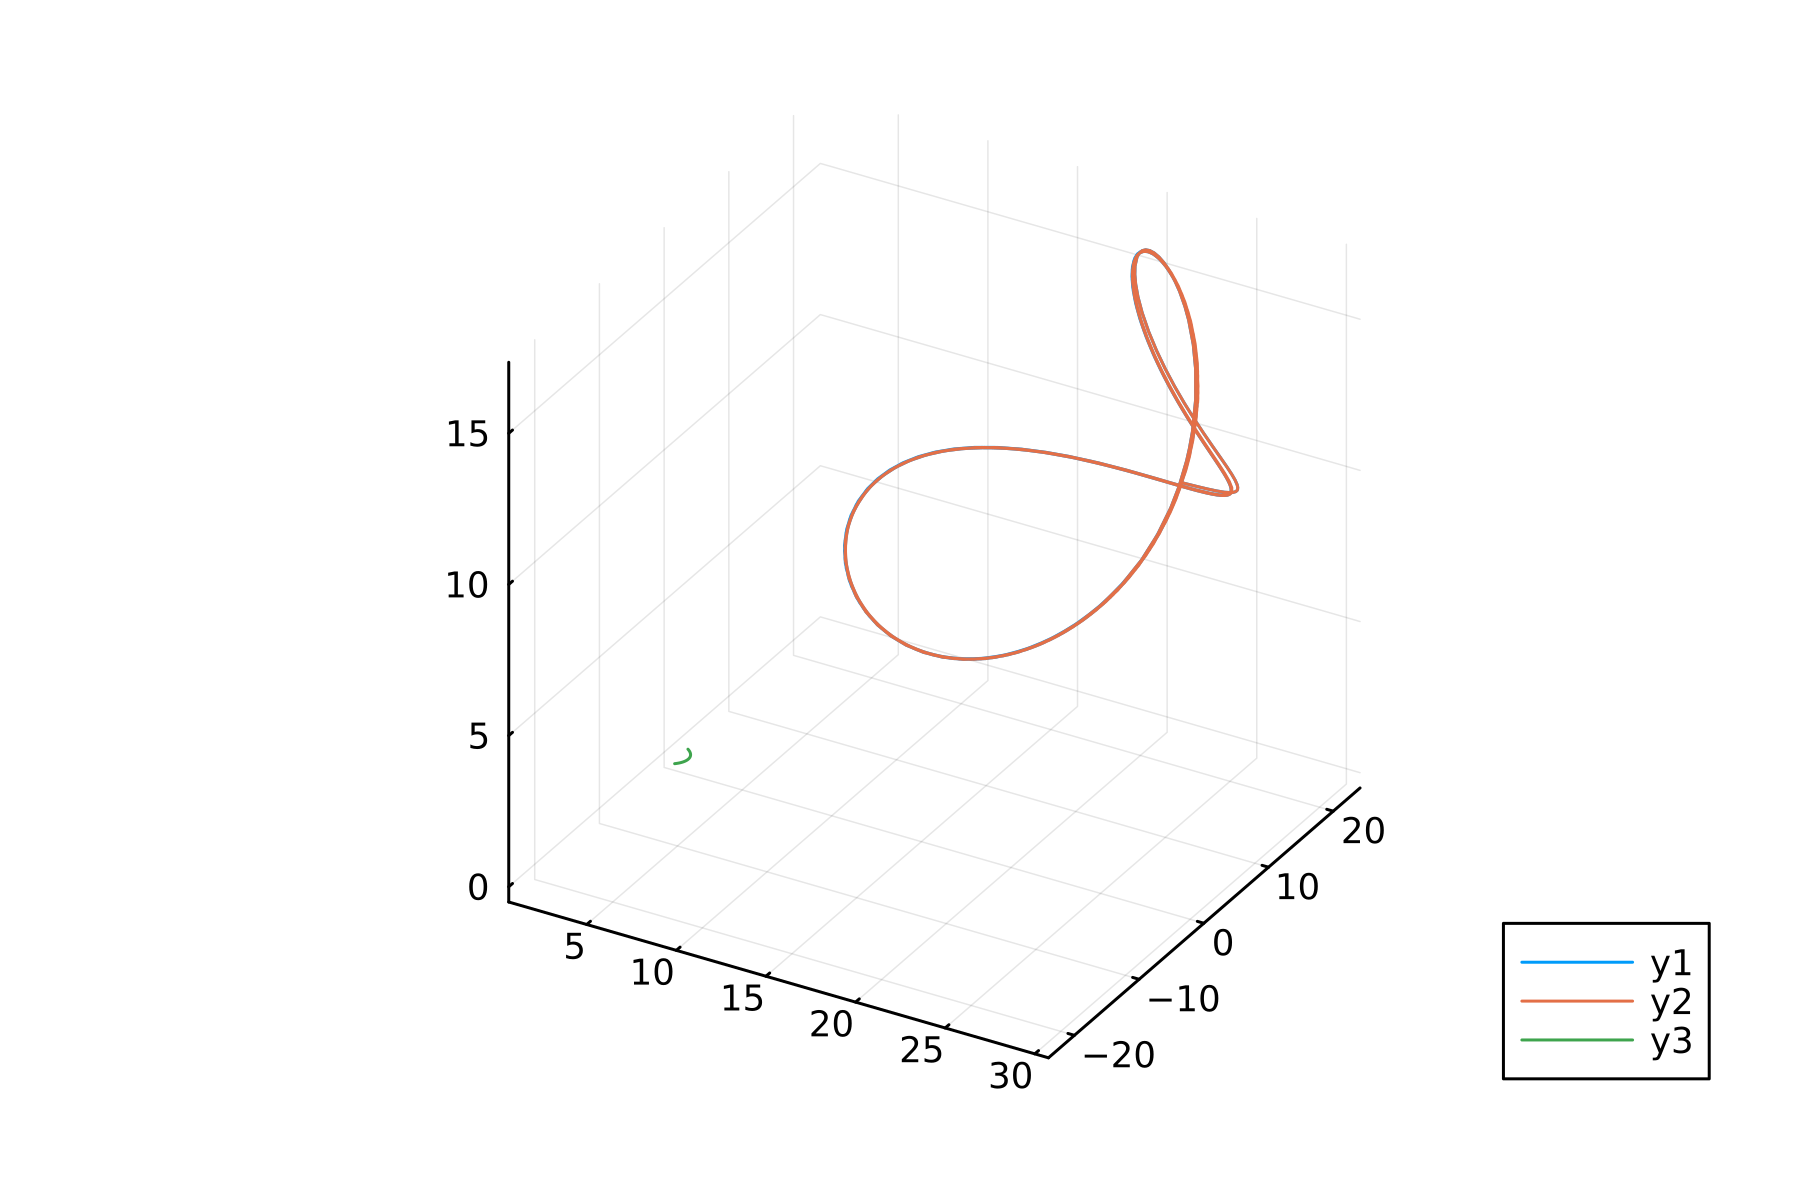

In [13]:
println("Graphic representing the movement of the kite's sail as a function of time")
plot(p_kite2[:,1],p_kite2[:,2],p_kite2[:,3], fmt=:png, dpi=300)
plot!(p_kite[:,1],p_kite[:,2],p_kite[:,3])
plot!(P_A[:,1],P_A[:,2],P_A[:,3])

<a id='ID8'>

### 3) Calculation of the power produced by the system

The aim of the project is to maximize the electricity production of the kite sail, which is why we are interested in the power produced by the system, and more precisely the average power.
The calculation of the power that was given in Python is done after integration and the average of the powers thus calculated is given by ```mean(Powers)```.

#### Calculation of the mean power using the trapezoidal rule :

In [14]:
function calcul_Puissance_moyenne(vecteur,longueur,vec_temps) 
    integrale = 0
    for k in 1:longueur-1
        h = vec_temps[k+1]-vec_temps[k]
        integrale = integrale + (vecteur[k+1]+vecteur[k])*h /2
    end
    return integrale
end

calcul_Puissance_moyenne (generic function with 2 methods)

### Graphic made in Python, representing the power of the system :

Average power :6879.981479628907


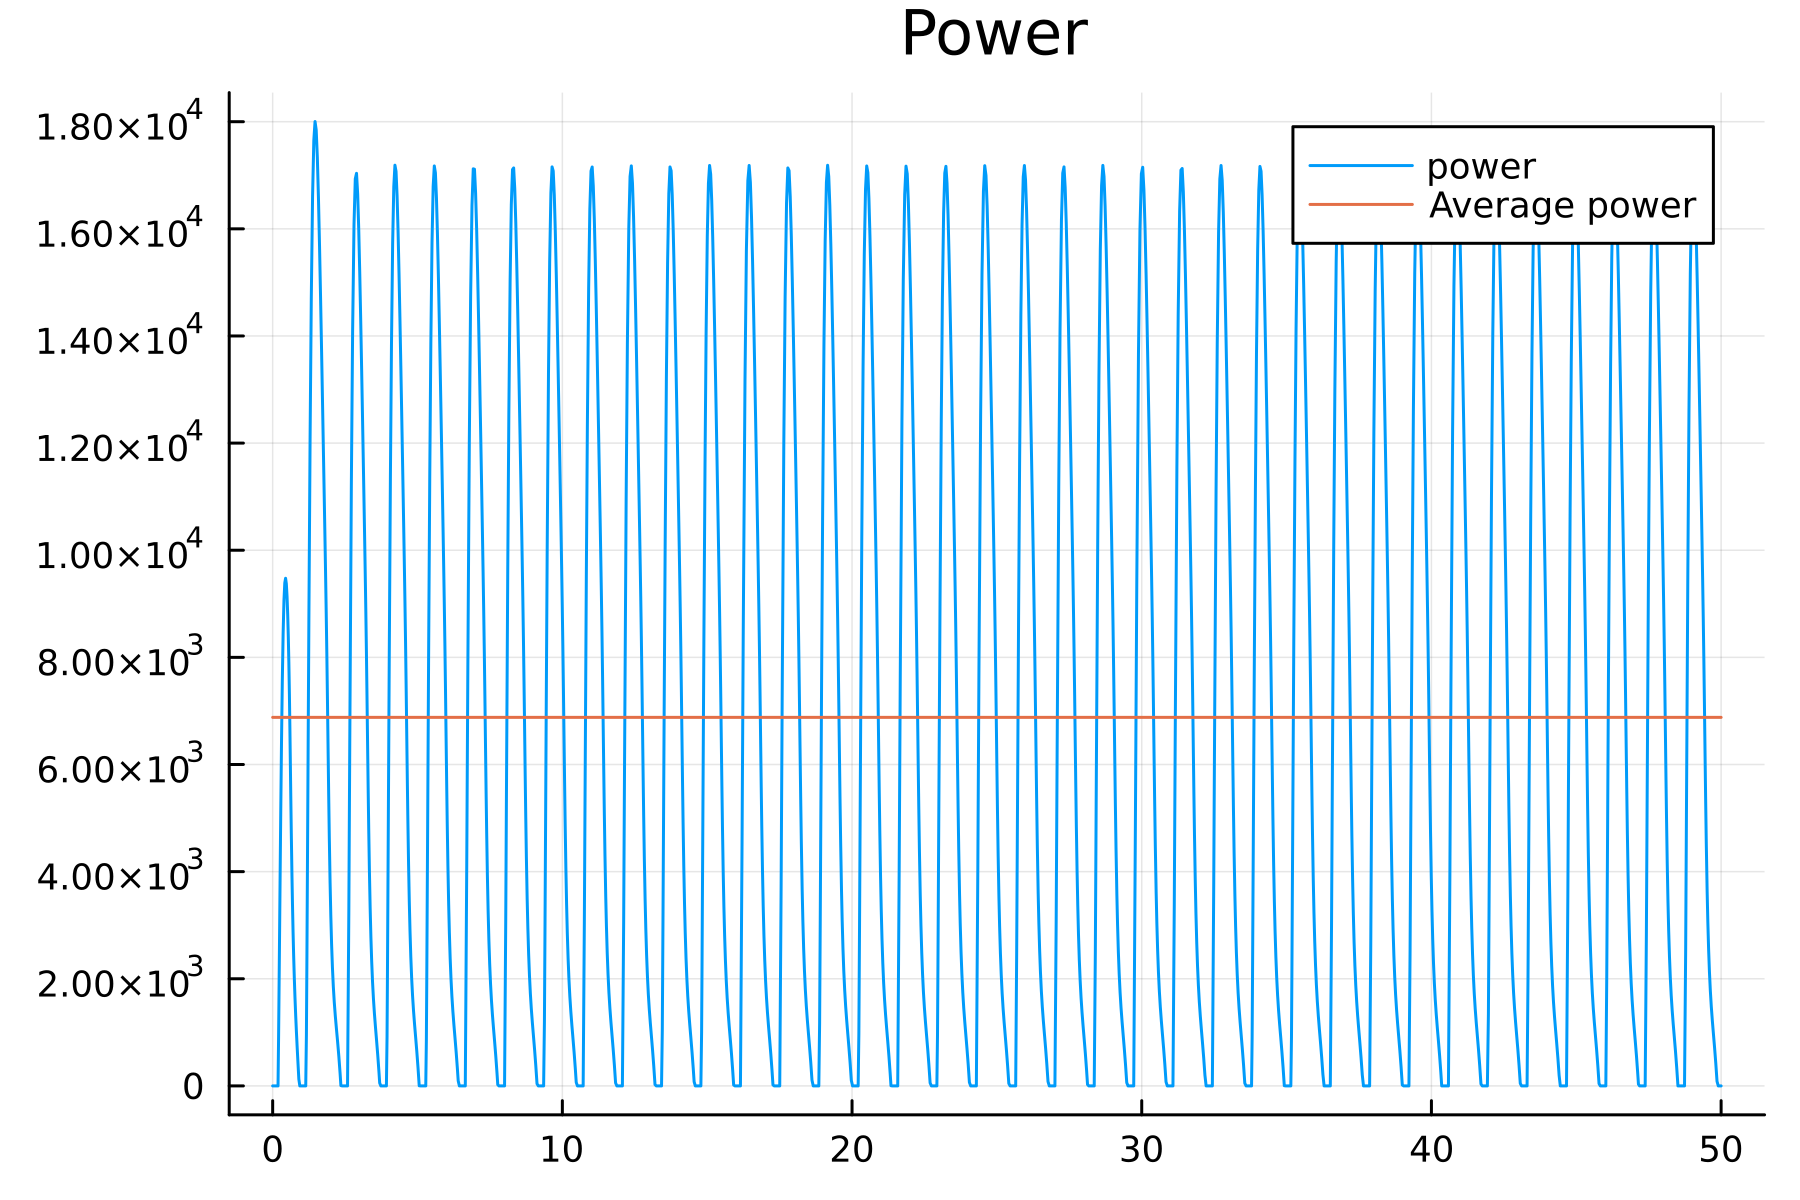

In [15]:
Puissance = calcul_Puissance.(alphal,alpha_point,alpha_p_max, Cmax)
print("Average power :")
println(mean(Puissance))
plot(temps, Puissance', title="Power",label="power",yticks=0:2000:20000, fmt=:png, dpi=300)
plot!(temps, transpose(mean(Puissance)*transpose(ones(( size(alphal)[2],1 )))) , label="Average power",yticks=0:2000:20000 )

#Calculation of powers thanks to the final matrix 

We changed the power calculation by calculating the power during the integration instead, by adding the power calculation to the second member of the ODE. We used the trapezoidal rule to calculate the average power. This allows us to gain precision and facilitate the optimization process.


### Graphic made in Julia, representing the power of the system :

Average power :169495.2810542133


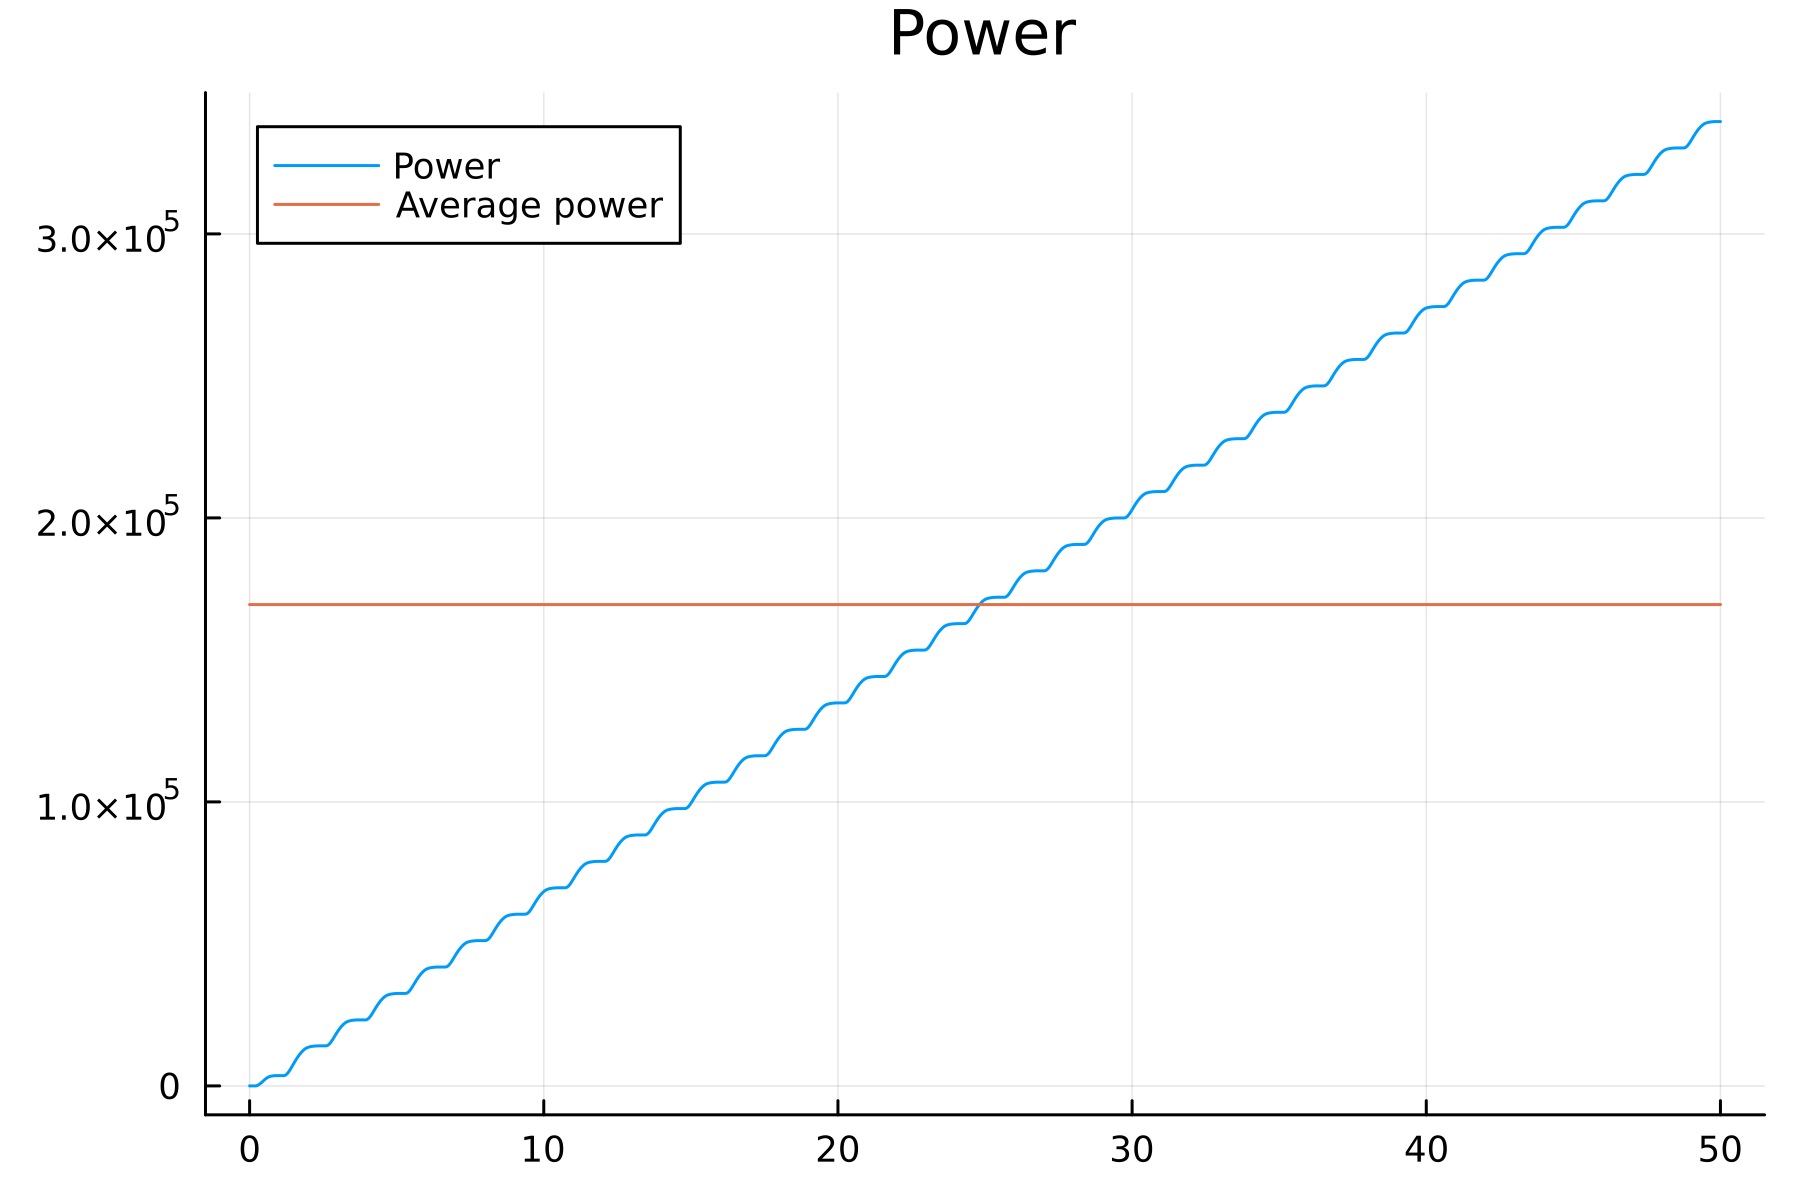

In [16]:
print("Average power :")
Puis_moy=calcul_Puissance_moyenne(transpose(Puissa),size(Puissa)[2],temps)
Puis_moy=Puis_moy/(temps[end]-temps[1])
println(Puis_moy)
plot(temps, transpose(Puissa), title="Power",label="Power", fmt=:png, dpi=300)
plot!(temps, transpose(Puis_moy*transpose(ones(( size(Puissa)[2],1 )))) , label="Average power" )

#Calculation of the power by adding the calculation in the second member of the ODE (better)

<a id='ID9'>

## **III- Optimization**

<a id='ID10'>

### 1) Influence of Cmax on the power  

As far as optimisation is concerned, we did not have time to do any further research, but we were able to conduct studies on various parameters such as Cmax, alpha_p_max or r, corresponding respectively to the torque associated with the Cg control law in N.m, to the angle travelled per second of the angle of rotation between the R2 reference frame and the R1 reference frame around the *$\vec{z_1}$* vector, and the length of the lines in meters.

Here is a graphics to help the comprehension of alpha_p_max i.e $ \dot α_m $ :

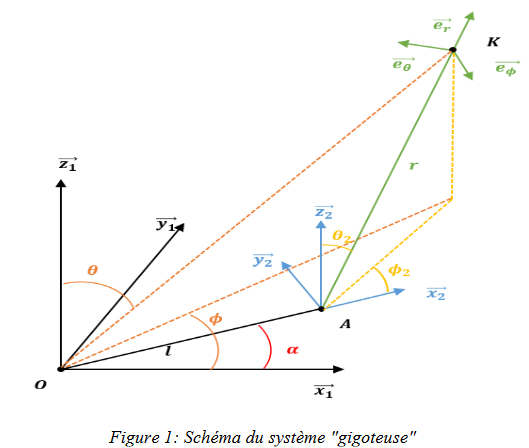

We have chosen to study the value of these parameters because they directly influence the behavior of the kite. Indeed, these 3 parameters are initially fixed with values equal to 15000 N.m for Cmax, approximately 90°, written as 1.57 corresponding to *$\frac{π}{2}$* for alpha_p_max and 31 m for r. In this first part we will study the influence of Cmax on the average power of the system. 
In order to conduct the study we chose to display the graph representing the average power as a function of the Cmax value. More precisely, we displayed 2 graphs: the first one giving a general view with a large variation of Cmax and a second one refining the best value of Cmax. 

On this first graph we clearly see a peak around 12500 N. :


The maximum of the average power is 180415.67862663633 and is reach for Cmax = 12500


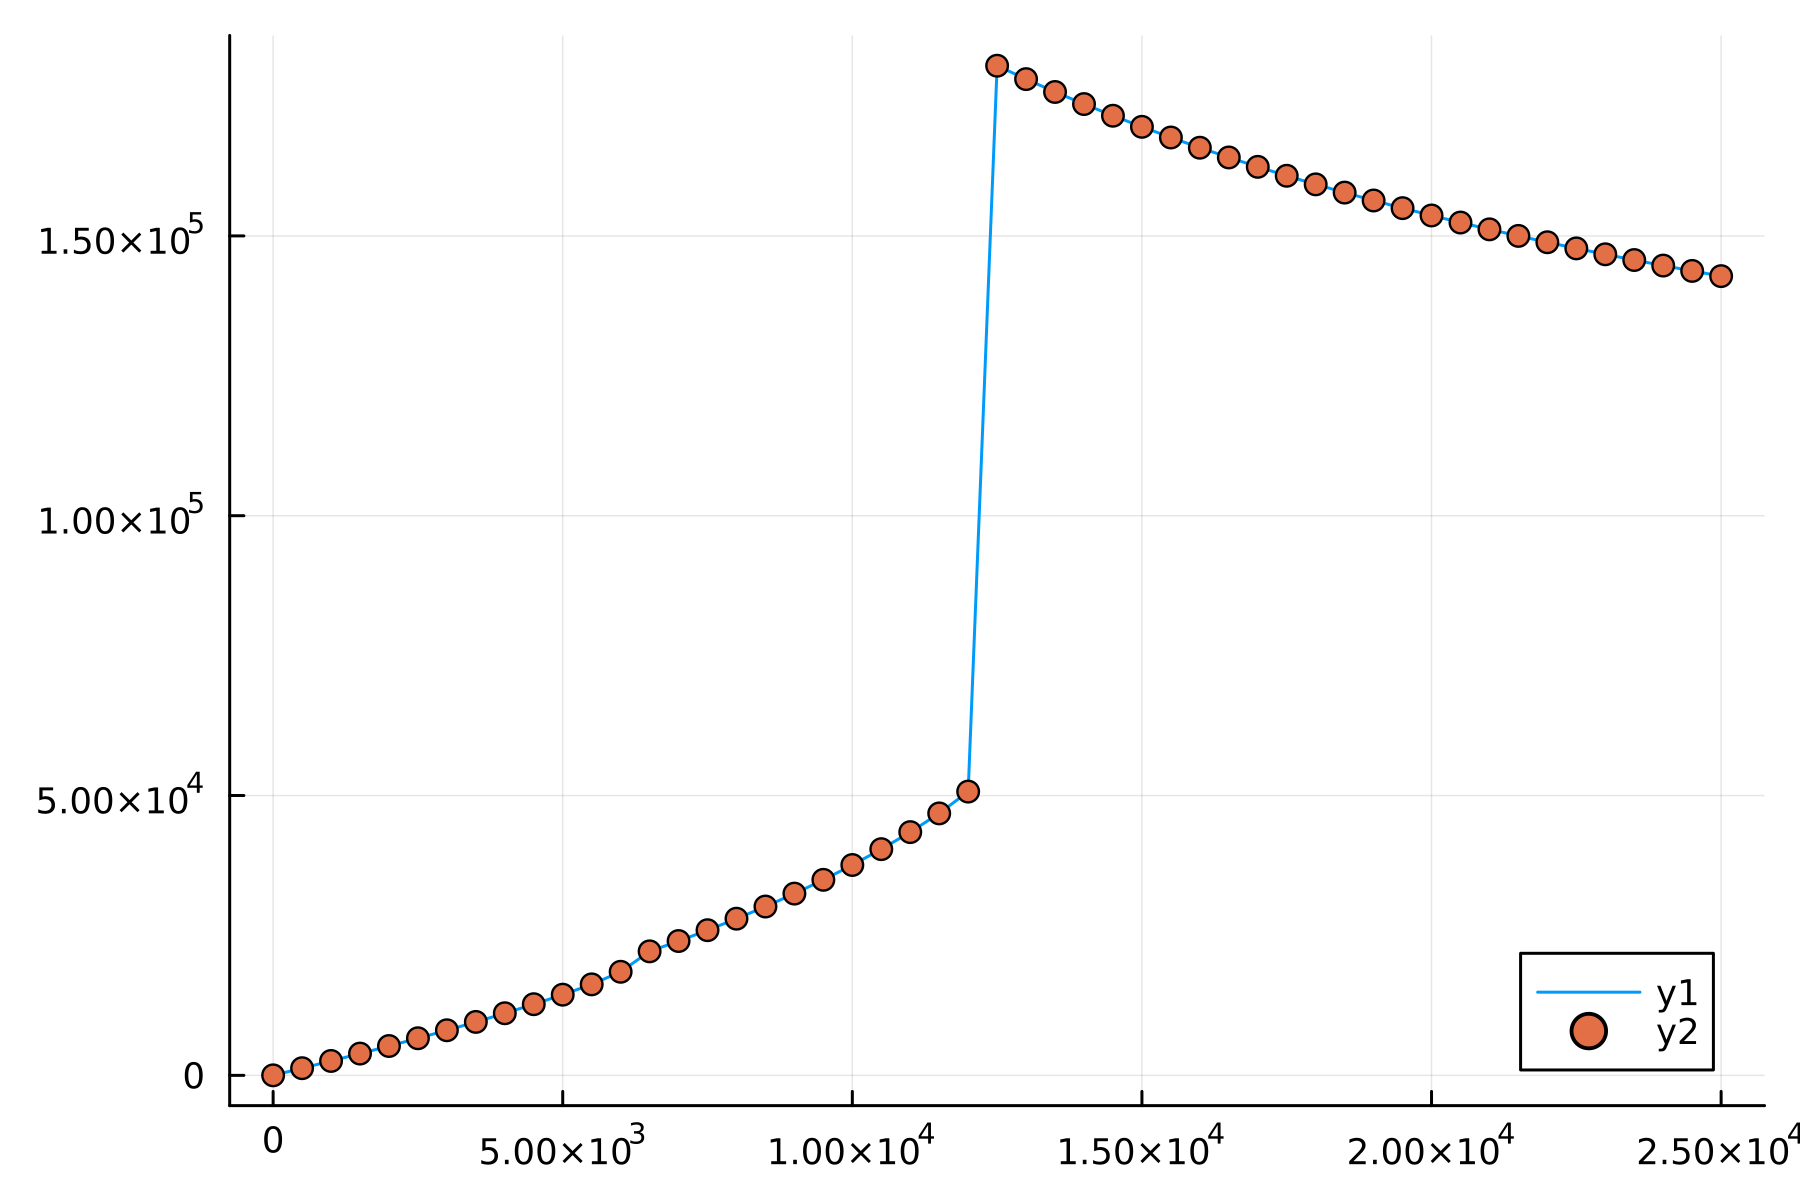

In [17]:
liste=[]
Cmaxmax=0
x=range(0,50)
for i in 0:50

Cmax = i*500

dalpha_init, dphi_2_init, dtheta_2_init, dR_init, dtau_init = vitesse_init(alpha_init, phi_2_init, theta_2_init, R_init, tau_init)
P_init=calcul_Puissance_init(alpha_init,dalpha_init,alpha_p_max,Cmax)
y0 = [tau_init ,dtau_init, alpha_init, dalpha_init, theta_2_init, dtheta_2_init, phi_2_init, dphi_2_init, R_init, dR_init,P_init]
p=[l, r, theta_0, delta_theta, phi_0, delta_phi, v_ref, I, m, alpha_p_max, Cmax,  AoA]
tspan = (0.0,50.0)
alg = Tsit5()
prob = ODEProblem(systeme2!,y0,tspan,p)
sol = solve(prob,reltol=1e-5)
A=sol.u
temps=sol.t

Puissa=zeros(1,size(A)[1])
for k in 1:size(A)[1]
    Puissa[1,k]=A[k][11]
end

Puis_moy=calcul_Puissance_moyenne(transpose(Puissa),size(Puissa)[2],temps)
Puis_moy=Puis_moy/(temps[end]-temps[1])

append!(liste,Puis_moy)
if Puis_moy == maximum(liste)
        Cmaxmax=Cmax
end
end
println()
println("The maximum of the average power is " ,maximum(liste)," and is reach for Cmax = ",Cmaxmax)
plot(x.*500,liste, fmt=:png, dpi=300)
p=scatter!(x.*500,liste)
display(p)

and by refining this result we realize that the optimal Cmax parameter is rather around Cmax = 12090 N.m :


The maximum of the average power is 182466.84660138295 and is reach for Cmax = 12090


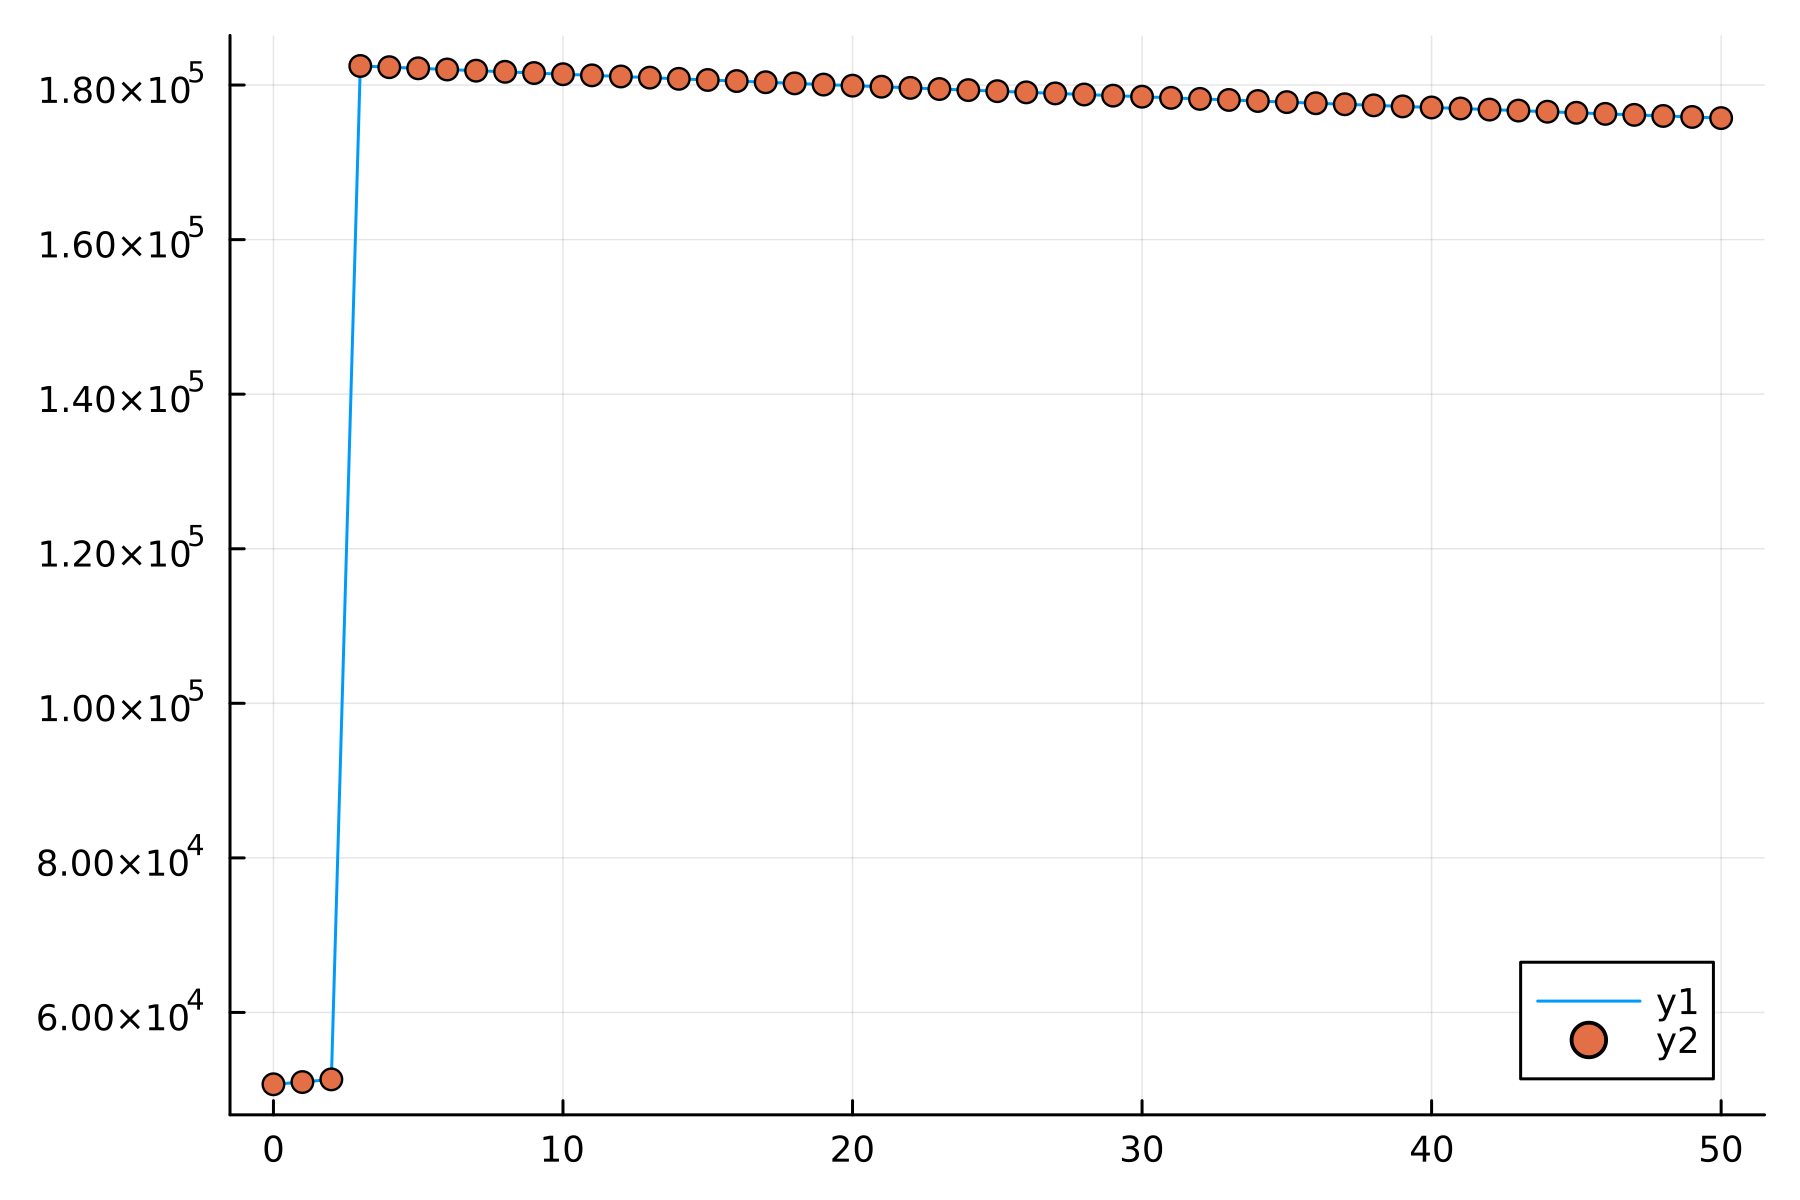

In [18]:
liste=[]
Cmaxmax=0
x=range(0,50)
for i in 0:50

Cmax = 12000+i*30

dalpha_init, dphi_2_init, dtheta_2_init, dR_init, dtau_init = vitesse_init(alpha_init, phi_2_init, theta_2_init, R_init, tau_init)
P_init=calcul_Puissance_init(alpha_init,dalpha_init,alpha_p_max,Cmax)
y0 = [tau_init ,dtau_init, alpha_init, dalpha_init, theta_2_init, dtheta_2_init, phi_2_init, dphi_2_init, R_init, dR_init,P_init]
p=[l, r, theta_0, delta_theta, phi_0, delta_phi, v_ref, I, m, alpha_p_max, Cmax,  AoA]
tspan = (0.0,50.0)
#alg = Tsit5()
prob = ODEProblem(systeme2!,y0,tspan,p)
sol = solve(prob,reltol=1e-5)
A=sol.u
temps=sol.t

Puissa=zeros(1,size(A)[1])
for k in 1:size(A)[1]
    Puissa[1,k]=A[k][11]
end

Puis_moy=calcul_Puissance_moyenne(transpose(Puissa),size(Puissa)[2],temps)
Puis_moy=Puis_moy/(temps[end]-temps[1])

append!(liste,Puis_moy)
if Puis_moy == maximum(liste)
        Cmaxmax=Cmax
end
end
println()
println("The maximum of the average power is " ,maximum(liste)," and is reach for Cmax = ",Cmaxmax)
plot(x,liste, fmt=:png, dpi=300)
p=scatter!(x,liste)
display(p)

<a id='ID11'>

### 2) Influence of alpha_p_max on the power  

In this second part we chose to continue the study of the parameters by keeping the best value of Cmax: Cmax = 12090 N.m because this gave a better average power value.
Thus, by making a study of the parameter alpha_p_max we observed a better value close to 2.3 for the max :



The maximum of average power is 238477.4279949615 and is reach for alpha_p_max = 3.3000000000000003


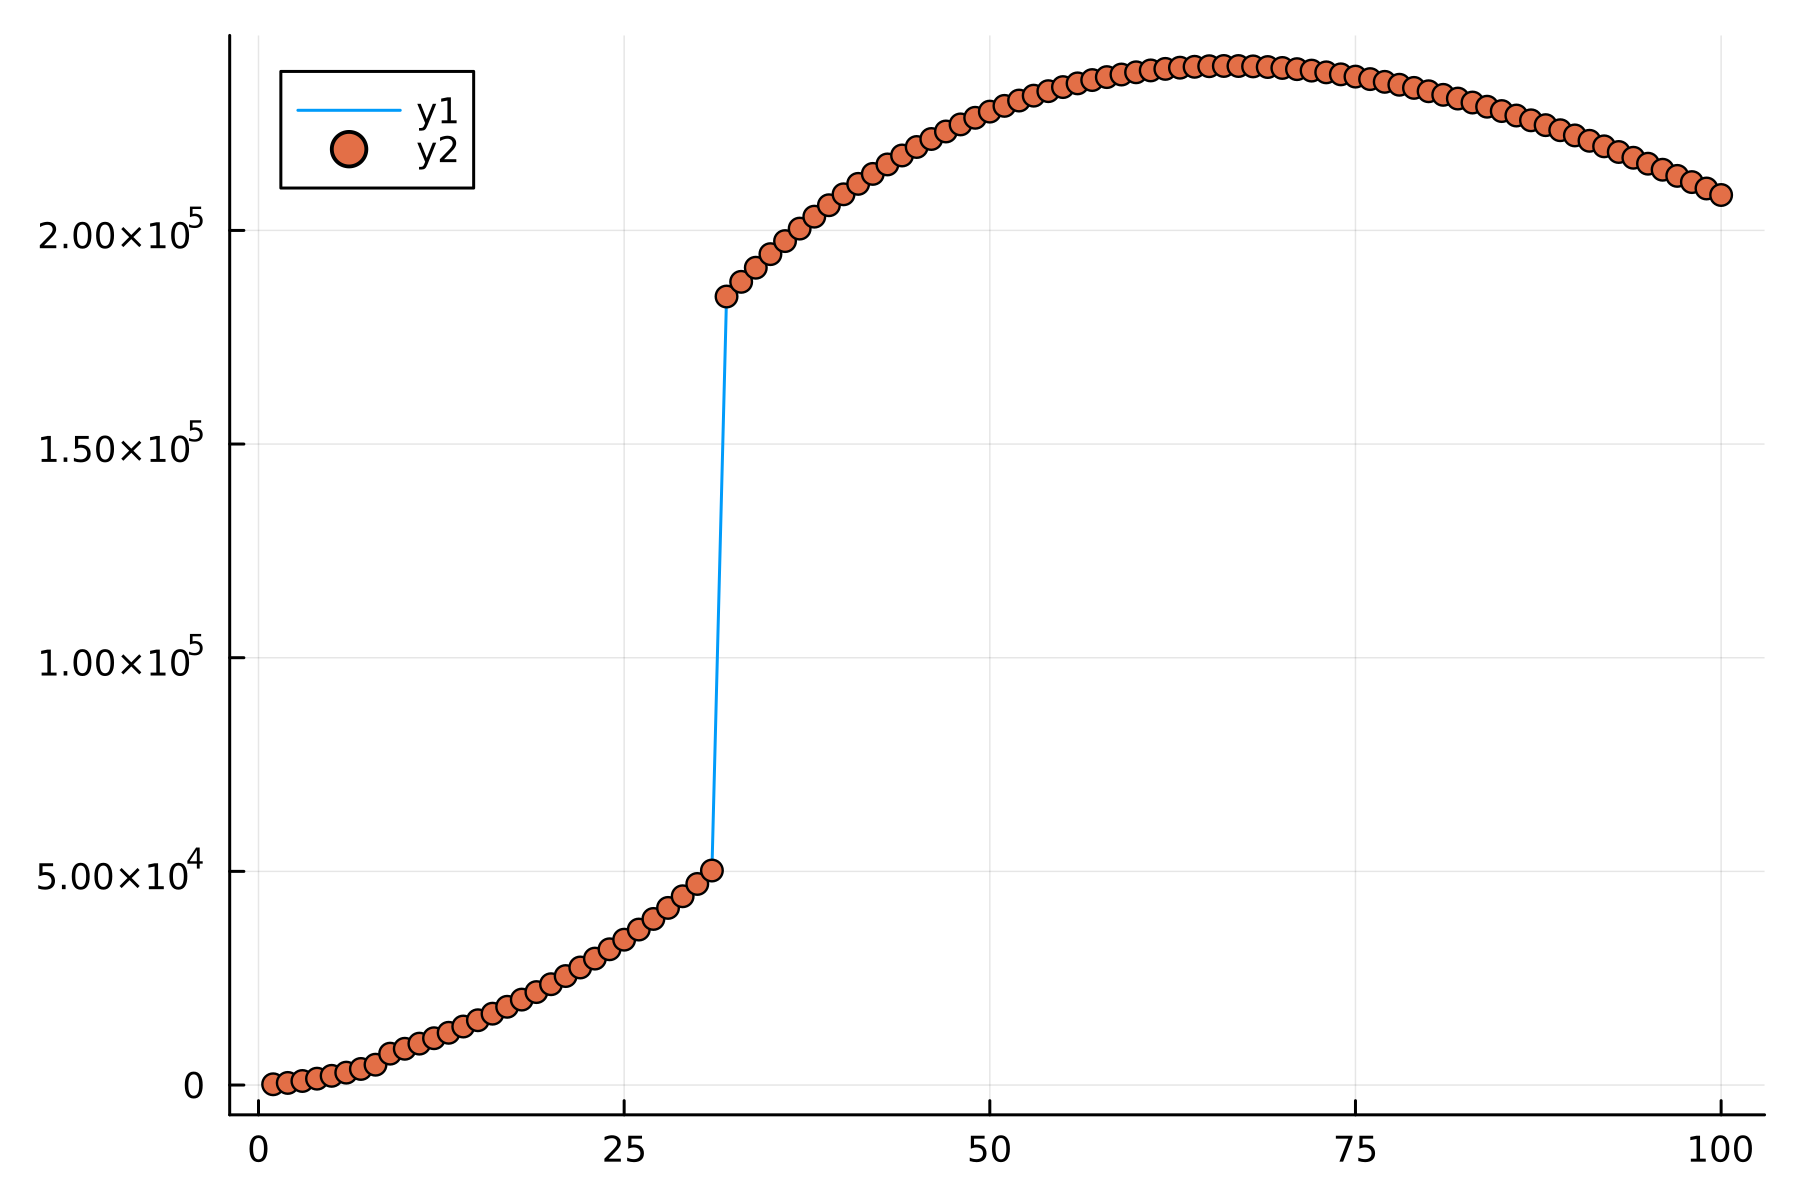

In [19]:
Cmax=12090
liste=[]
alphamax=0
x=range(1,100)
for i in 1:100

alpha_p_max = i*0.05

dalpha_init, dphi_2_init, dtheta_2_init, dR_init, dtau_init = vitesse_init(alpha_init, phi_2_init, theta_2_init, R_init, tau_init)
P_init=calcul_Puissance_init(alpha_init,dalpha_init,alpha_p_max,Cmax)
y0 = [tau_init ,dtau_init, alpha_init, dalpha_init, theta_2_init, dtheta_2_init, phi_2_init, dphi_2_init, R_init, dR_init,P_init]
p=[l, r, theta_0, delta_theta, phi_0, delta_phi, v_ref, I, m, alpha_p_max, Cmax,  AoA]
tspan = (0.0,50.0)
alg = Tsit5()
prob = ODEProblem(systeme2!,y0,tspan,p)
sol = solve(prob,reltol=1e-5)
A=sol.u
temps=sol.t

Puissa=zeros(1,size(A)[1])
for k in 1:size(A)[1]
    Puissa[1,k]=A[k][11]
end

Puis_moy=calcul_Puissance_moyenne(transpose(Puissa),size(Puissa)[2],temps)
Puis_moy=Puis_moy/(temps[end]-temps[1])

append!(liste,Puis_moy)
if Puis_moy == maximum(liste)
        alphamax=alpha_p_max
end
end

println()
println("The maximum of average power is " ,maximum(liste)," and is reach for alpha_p_max = ",alphamax)
plot(x,liste, fmt=:png, dpi=300)
p=scatter!(x,liste)
display(p)

By further refining this result, we find a value of 2.29 :


The maximum of average power is 221390.33796071808 and is reach for alpha_p_max = 2.3000000000000003


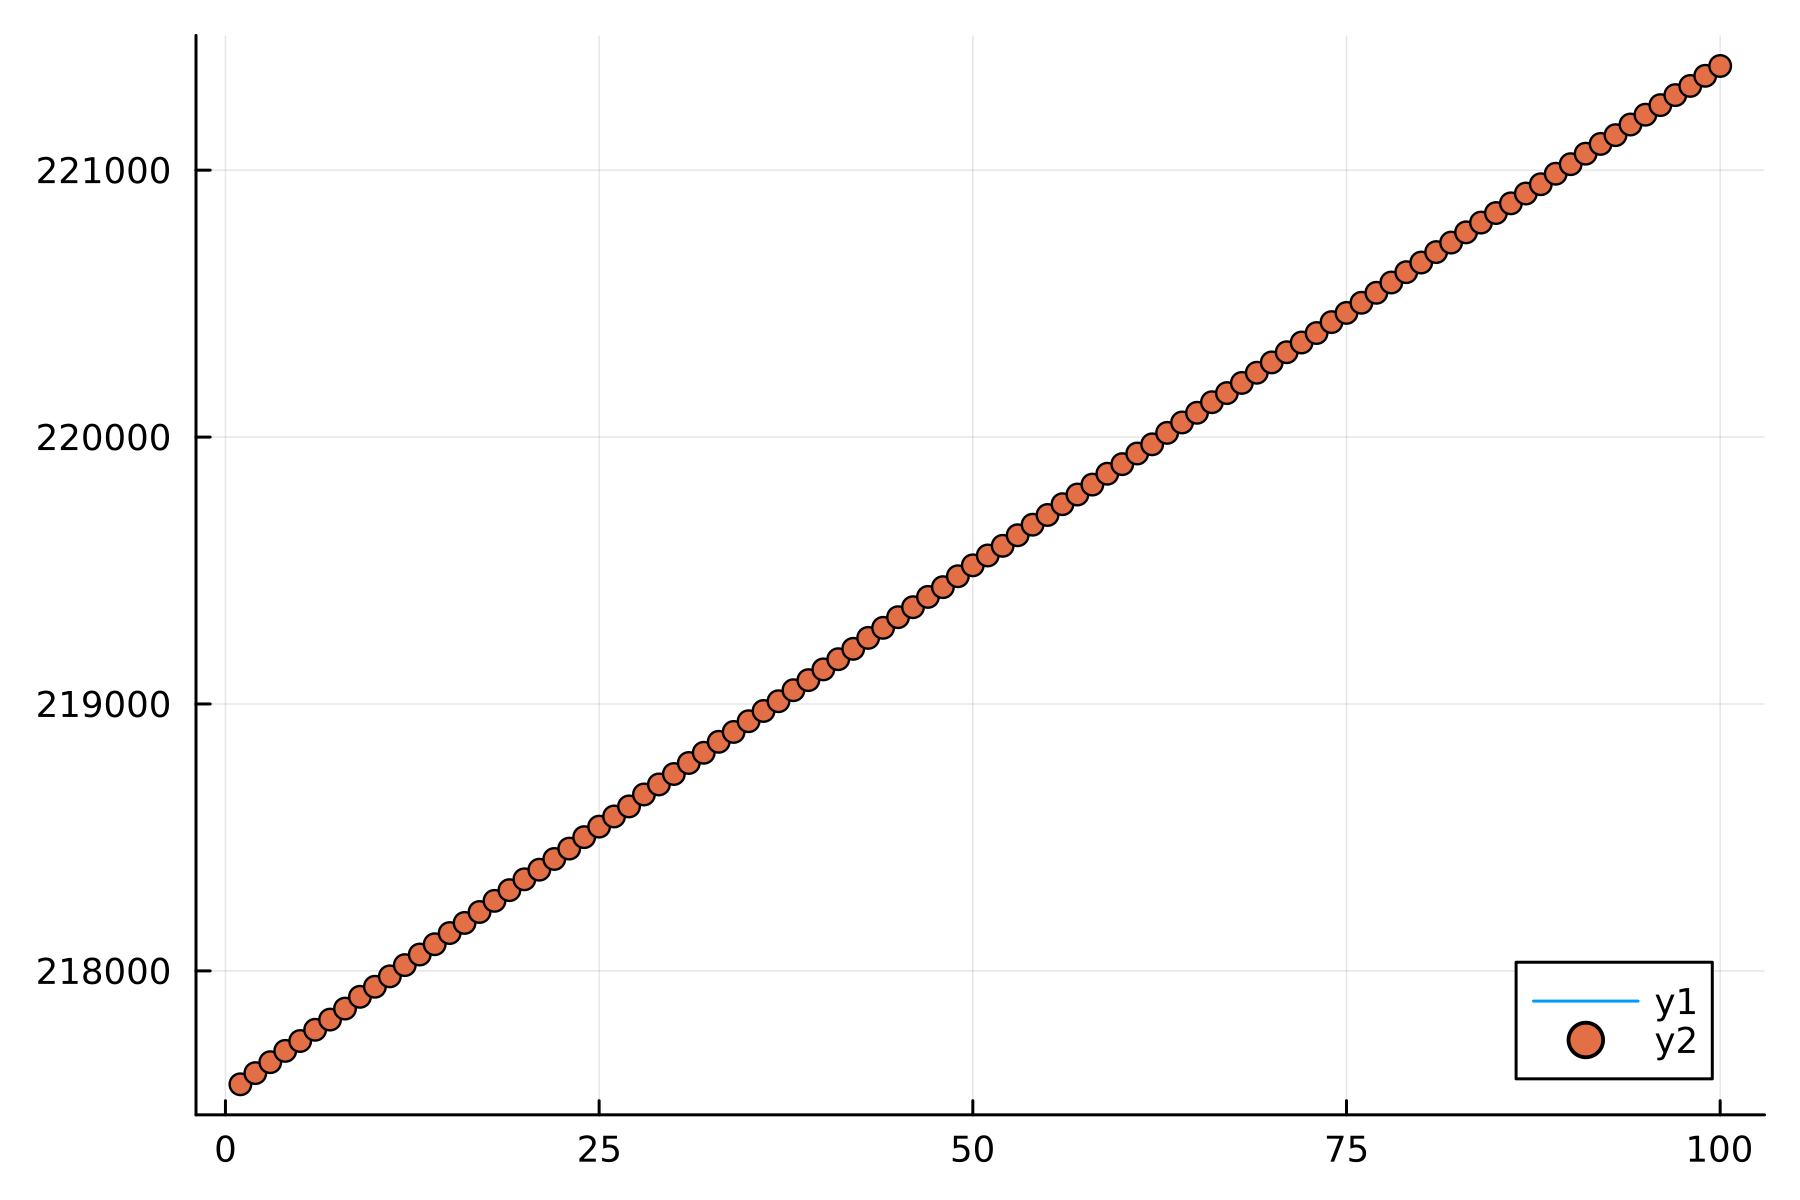

In [20]:
Cmax=12090
liste=[]
alphamax=0
x=range(1,100)
for i in 1:100

alpha_p_max = 2.2+i*0.001

dalpha_init, dphi_2_init, dtheta_2_init, dR_init, dtau_init = vitesse_init(alpha_init, phi_2_init, theta_2_init, R_init, tau_init)
P_init=calcul_Puissance_init(alpha_init,dalpha_init,alpha_p_max,Cmax)
y0 = [tau_init ,dtau_init, alpha_init, dalpha_init, theta_2_init, dtheta_2_init, phi_2_init, dphi_2_init, R_init, dR_init,P_init]
p=[l, r, theta_0, delta_theta, phi_0, delta_phi, v_ref, I, m, alpha_p_max, Cmax,  AoA]
tspan = (0.0,50.0)
#alg = Tsit5()
prob = ODEProblem(systeme2!,y0,tspan,p)
sol = solve(prob,reltol=1e-5)
A=sol.u
temps=sol.t

Puissa=zeros(1,size(A)[1])
for k in 1:size(A)[1]
    Puissa[1,k]=A[k][11]
end



Puis_moy=calcul_Puissance_moyenne(transpose(Puissa),size(Puissa)[2],temps)
Puis_moy=Puis_moy/(temps[end]-temps[1])

append!(liste,Puis_moy)
if Puis_moy == maximum(liste)
        alphamax=alpha_p_max
end
end

println()
println("The maximum of average power is " ,maximum(liste)," and is reach for alpha_p_max = ",alphamax)
plot(x,liste)
p=scatter!(x,liste, fmt=:png, dpi=300)
display(p)

<a id='ID12'>

### 3) Influence of r on the power  

Finally, we tested the influence of r i.e the length of the lines on the average power of the system. We still kept the best values previously calculated, namely Cmax = 12090 N.m and alpha_p_max = 2.29.
The first graph gives us an increasing then decreasing curve with a maximum reached in r = 38.5 m :



The maximum of average power is 236980.02107787374 and is reach for r = 39.0


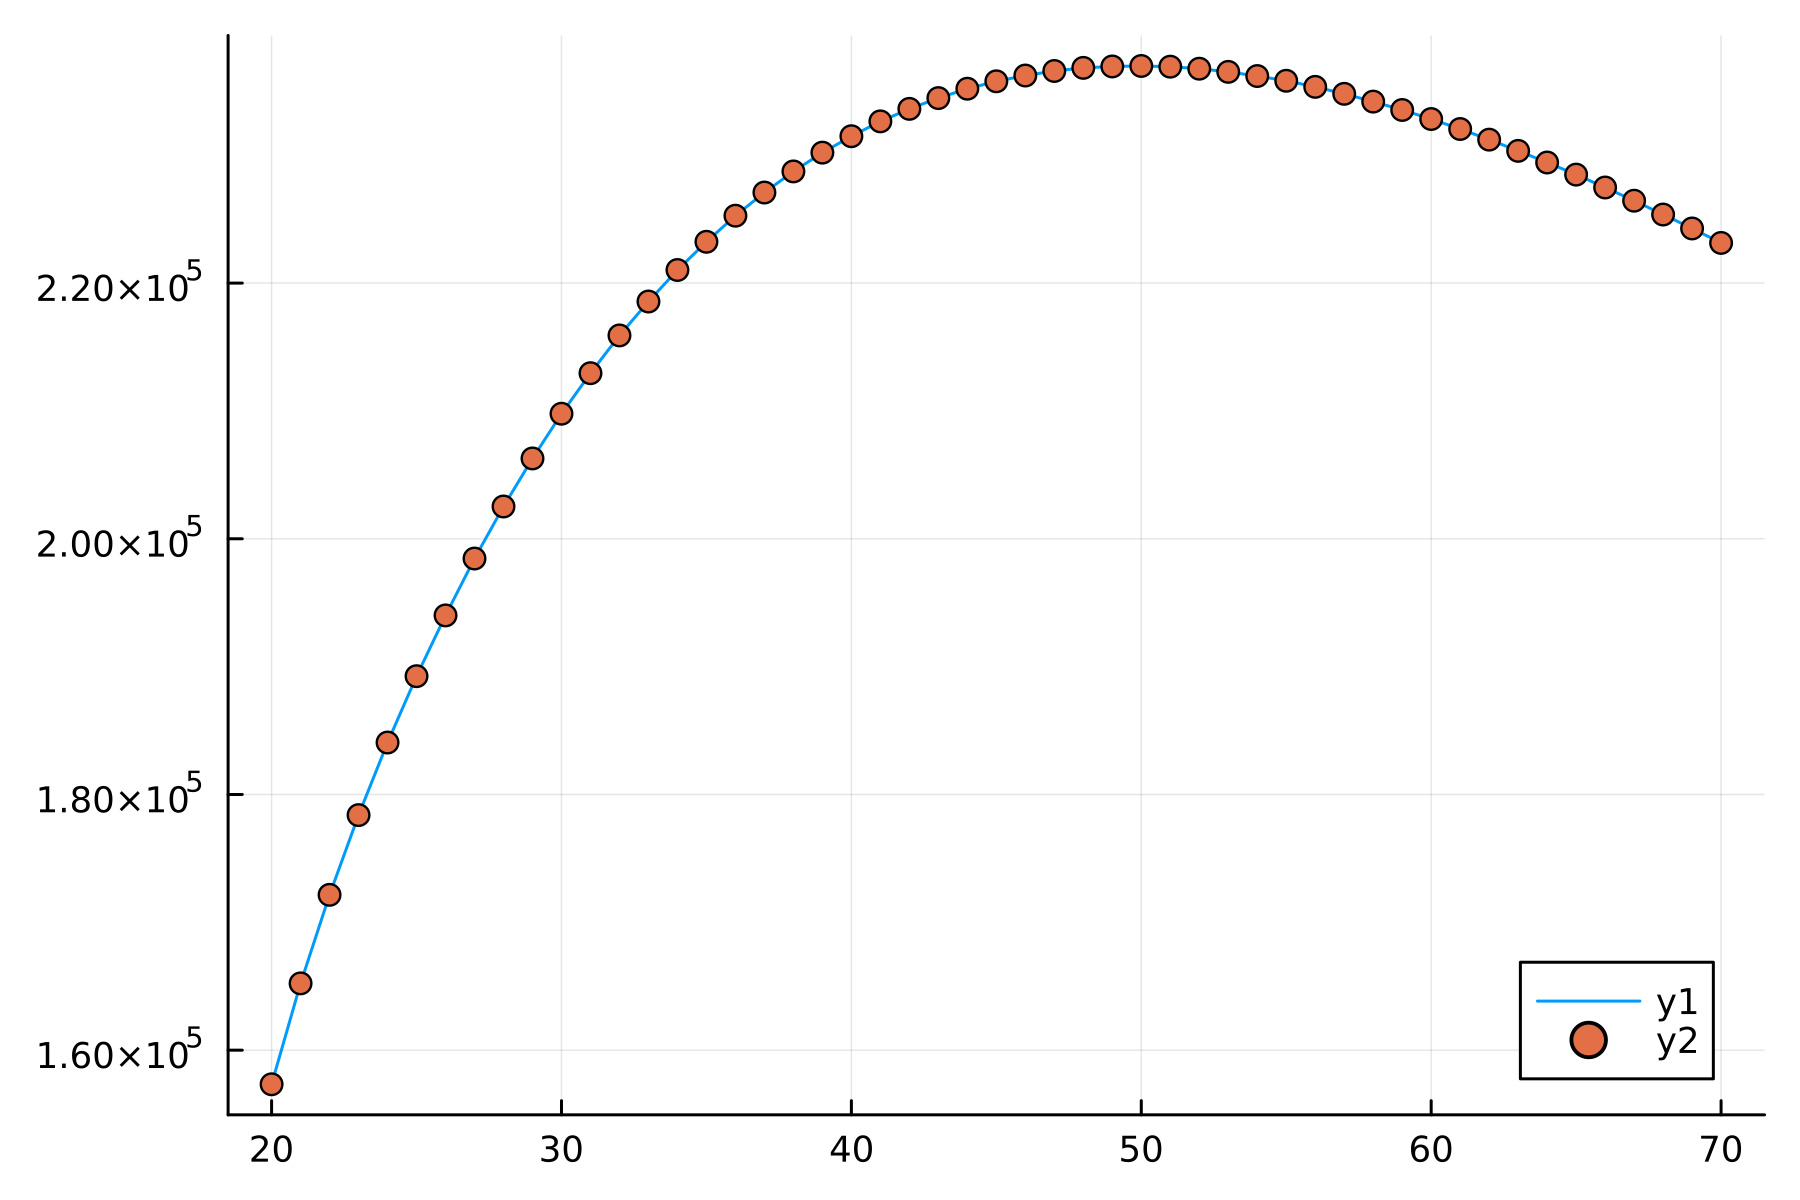

In [21]:
Cmax = 12090
alpha_p_max = 2.29   #31

liste=[]
rmax=0
x=range(20,70)
for i in 20:70

r = 14+i*0.5

dalpha_init, dphi_2_init, dtheta_2_init, dR_init, dtau_init = vitesse_init(alpha_init, phi_2_init, theta_2_init, R_init, tau_init)
P_init=calcul_Puissance_init(alpha_init,dalpha_init,alpha_p_max,Cmax)
y0 = [tau_init ,dtau_init, alpha_init, dalpha_init, theta_2_init, dtheta_2_init, phi_2_init, dphi_2_init, R_init, dR_init,P_init]
p=[l, r, theta_0, delta_theta, phi_0, delta_phi, v_ref, I, m, alpha_p_max, Cmax,  AoA]
tspan = (0.0,50.0)
alg = Tsit5()
prob = ODEProblem(systeme2!,y0,tspan,p)
sol = solve(prob,reltol=1e-5)
A=sol.u
temps=sol.t

Puissa=zeros(1,size(A)[1])
for k in 1:size(A)[1]
    Puissa[1,k]=A[k][11]
end

Puis_moy=calcul_Puissance_moyenne(transpose(Puissa),size(Puissa)[2],temps)
Puis_moy=Puis_moy/(temps[end]-temps[1])

append!(liste,Puis_moy)
if Puis_moy == maximum(liste)
    rmax=r
end
end
println()
println("The maximum of average power is " ,maximum(liste)," and is reach for r = ",rmax)
plot(x,liste, fmt=:png, dpi=300)
p=scatter!(x,liste)
display(p)

The second graph gives a better approximation with a r value equal to 38.85m :


The maximum of average power is 236980.72237285282 and is reach for r = 39.05


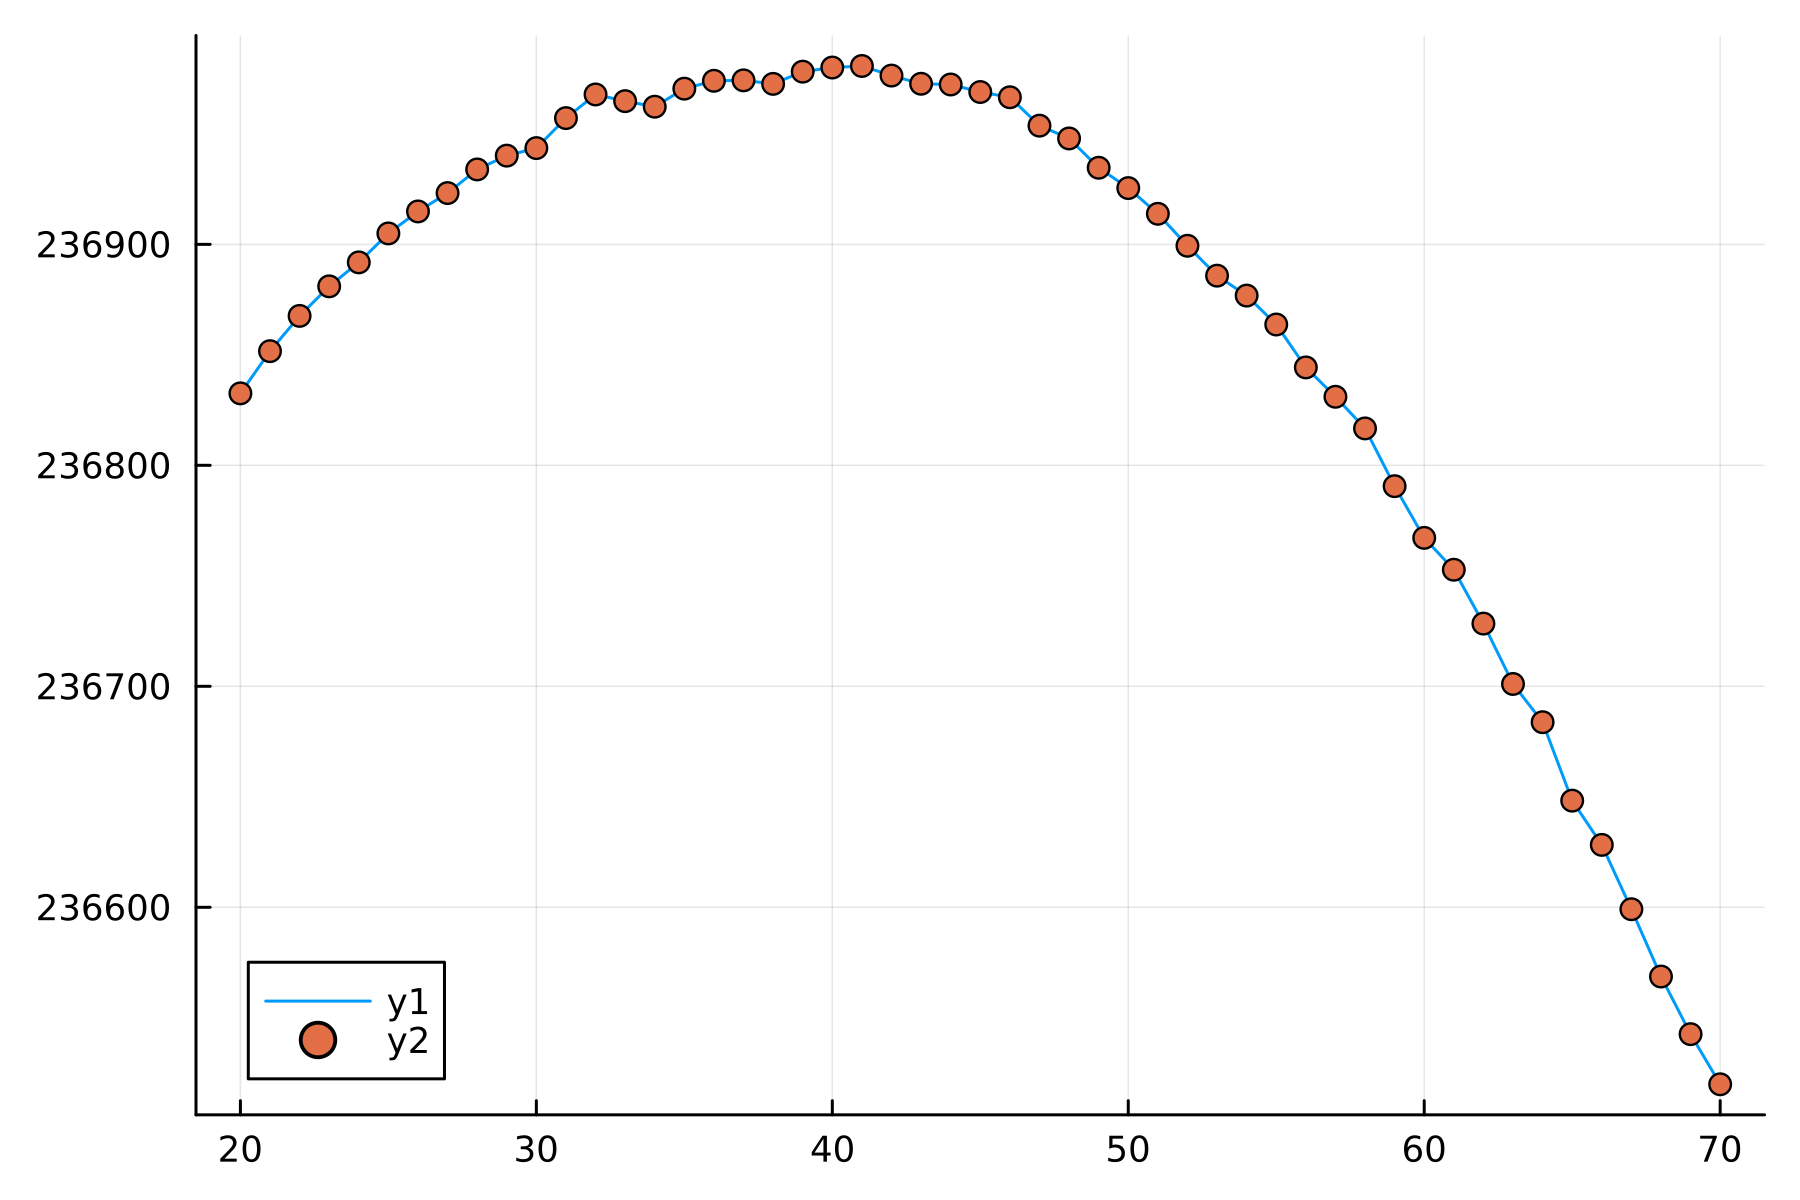

In [22]:
Cmax = 12090
alpha_p_max = 2.29   #31

liste=[]
rmax=0
x=range(20,70)
for i in 20:70

r = 37 + i*0.05

dalpha_init, dphi_2_init, dtheta_2_init, dR_init, dtau_init = vitesse_init(alpha_init, phi_2_init, theta_2_init, R_init, tau_init)
P_init=calcul_Puissance_init(alpha_init,dalpha_init,alpha_p_max,Cmax)
y0 = [tau_init ,dtau_init, alpha_init, dalpha_init, theta_2_init, dtheta_2_init, phi_2_init, dphi_2_init, R_init, dR_init,P_init]
p=[l, r, theta_0, delta_theta, phi_0, delta_phi, v_ref, I, m, alpha_p_max, Cmax,  AoA]
tspan = (0.0,50.0)
alg = Tsit5()
prob = ODEProblem(systeme2!,y0,tspan,p)
sol = solve(prob,reltol=1e-5)
A=sol.u
temps=sol.t

Puissa=zeros(1,size(A)[1])
for k in 1:size(A)[1]
    Puissa[1,k]=A[k][11]
end

Puis_moy=calcul_Puissance_moyenne(transpose(Puissa),size(Puissa)[2],temps)
Puis_moy=Puis_moy/(temps[end]-temps[1])

append!(liste,Puis_moy)
if Puis_moy == maximum(liste)
    rmax=r
end
end
println()
println("The maximum of average power is " ,maximum(liste)," and is reach for r = ",rmax)
plot(x,liste, fmt=:png, dpi=300)
p=scatter!(x,liste)
display(p)

<a id='ID13'>

<br>
<br>
<br>

## **IV -  Conclusion** 

Eventually, this KEEP project allowed us to discover new ways of working and a new programming language. It also faced us with difficulties to convert the code between programming languages. Nevertheless, we have seen the importance of optimizing parameters in an ODE and the influence this can have on the final performance of the system. Indeed, there is a difference of more than 20 000 Watt between the average power measured initially and the one obtained after optimisation. 

We should finally have a more "physical" look and see if the optimal values obtained are achievable on the system. These values do not change drastically compared to the initial values given to us, so it might be interesting to study this case and obtain a better yield for the production of electricity using this kite sail.

## Bibliographie
- Desenclos, K. Production d’électricité par voile de kite. ENSTA Bretagne